In [0]:
from google.colab import drive  


In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import math
import sympy as sy
from sympy import *
import pandas as pd
import cv2


In [5]:
import os
os.chdir(r'C:\Users\Kfor\Desktop\亚太\2019 APMCM Problems\2019 APMCM Problems\OriginResult')

os.environ['CUDA_VISIBLE_DEVICES']='1'  

In [6]:
#二氧化硅折射率
n = 1.548745
for oneImage in ['0511.bmp']:
    imageTest = cv2.imread(oneImage,0)

    [rows, cols] = np.shape(imageTest)
    # 能框住检测到的二氧化硅区域的最小矩形的四个边框的位置信息
    leftBorder = 0
    rightBorder = cols
    upBorder = 0
    downBorder = rows
    
    imageTestSorted = np.sort(imageTest,axis=None)[:,np.newaxis]
    imageTestSorted.astype(np.int)
    imageTestSorted = np.delete(imageTestSorted,np.where(imageTestSorted==0))[:,np.newaxis]
    imageTestLeft1 = np.concatenate([imageTestSorted[1:],[[np.max(imageTest)]]])
    
    # 最小灰度值，代表与CCD(相机)平行,由于边框扣取存在一定误差，可能会将二氧化硅f附近影子也包括进去，对像素点灰度进行排序取存在较大断崖式的地方最为sio2的灰度最低点
    imageTestDif = imageTestSorted - imageTestLeft1
    if imageTestDif[imageTestDif > 100].any():
        # mingrey_pos = np.index(np.max(imageTestDif))
        mingrey_pos = np.unravel_index(np.argmax(imageTestDif), imageTestDif.shape)
        min_grey = imageTestSorted[mingrey_pos[0], mingrey_pos[1]]
        [mingrey_pos_x, mingrey_pos_y] = np.unravel_index(
            min_grey, imageTest.shape)
    elif np.min(imageTest) > 15:
        min_grey = np.min(imageTest)
    else:
        min_grey = 15
    # min_grey = np.min(imageTest)
    # [mingrey_pos_x,mingrey_pos_y] = np.unravel_index(np.argmax(imageTest),imageTest.shape)
    # 最大反射光强
    max_I = min_grey*math.pow(n+1, 2)/math.pow(n-1, 2)

    # 用于存储物体高度的一个矩阵，将最高点定义为0，其余点均为负数
    thickness = np.zeros([rows, cols])
    thickness[mingrey_pos_x, mingrey_pos_y] = 0
    
    
    rou = imageTest / max_I

    x = sy.symbols('xi_ta')
    y = sy.symbols('rou')
    # expr = -1.061*x**5-3.3437*x**4+4.1582*x**3-2.38295*x**2+0.57975*x+0.0083-y

    # 对最小灰度值的点（即高度最高的点）左上部分根据灰度值求得高度变化的斜率从而计算坐上部分的高度
    for i in np.arange(upBorder+1, mingrey_pos_y)[::-1]:
        for j in np.arange(leftBorder+1, mingrey_pos_x)[::-1]:
            if(imageTest[i, j] != 0):
                expr = "0.03175*x**2-0.01495*x+0.0476-"+str(imageTest[i, j]/max_I)
                expr = sympify(expr)
                dhdx = sy.solve(expr)[1]
                if np.complex(dhdx):
                    thickness[i, j] = -255
                else:
                    thickness[i, j] = thickness[i, j+1] - dhdx
        if(i > upBorder+1 and imageTest[i-1, mingrey_pos_y] != 0):
            expr = "0.03175*x**2-0.01495*x+0.0476-" + \
                str(imageTest[i-1, mingrey_pos_y])
            expr = sympify(expr)
            dhdx = sy.solve(expr)[1]
            if np.iscomplex(dhdx):
                thickness[i-1, mingrey_pos_y] = -255
            else:
                thickness[i-1, mingrey_pos_y] = thickness[i, mingrey_pos_y] - dhdx
    # 对最小灰度值的点（即高度最高的点）右上部分根据灰度值求得高度变化的斜率从而计算坐上部分的高度
    for i in np.arange(upBorder+1, mingrey_pos_y)[::-1]:
        for j in np.arange(mingrey_pos_x+1, rightBorder):
            if(imageTest[i, j] != 0):
                expr = "0.03175*x**2-0.01495*x+0.0476-"+str(imageTest[i, j]/max_I)
                expr = sympify(expr)
                dhdx = sy.solve(expr)[1]
                if np.iscomplex(dhdx):
                    thickness[i, j] = -255
                else:
                    thickness[i, j] = thickness[i, j-1] - dhdx
                print(thickness[i, j])
        if(i > upBorder+1 and imageTest[i-1, mingrey_pos_y] != 0):
            expr = "0.03175*x**2-0.01495*x+0.0476-" + \
                str(imageTest[i-1, mingrey_pos_y])
            expr = sympify(expr)
            dhdx = sy.solve(expr)[1]
            if np.iscomplex(dhdx):
                thickness[i-1, mingrey_pos_y] = -255
            else:
                thickness[i-1, mingrey_pos_y] = thickness[i, mingrey_pos_y] - dhdx
            print(thickness[i-1, mingrey_pos_y])
    # 对最小灰度值的点（即高度最高的点）左下部分根据灰度值求得高度变化的斜率从而计算坐上部分的高度
    for i in np.arange(mingrey_pos_y+1, downBorder):
        for j in np.arange(leftBorder+1, mingrey_pos_x)[::-1]:
            if(imageTest[i, j] != 0):
                expr = "0.03175*x**2-0.01495*x+0.0476-"+str(imageTest[i, j]/max_I)
                expr = sympify(expr)
                dhdx = sy.solve(expr)[1]
                if np.iscomplex(dhdx):
                    thickness[i, j] = -255
                else:
                    thickness[i, j] = thickness[i, j+1] - dhdx
                print(thickness[i, j])
        if(i > downBorder-1 and imageTest[i+1, mingrey_pos_y] != 0):
            expr = "0.03175*x**2-0.01495*x+0.0476-" + \
                str(imageTest[i-1, mingrey_pos_y]/max_I)
            expr = sympify(expr)
            dhdx = sy.solve(expr)[1]
            if np.iscomplex(dhdx):
                thickness[i+1, mingrey_pos_y] = -255
            else:
                thickness[i+1, mingrey_pos_y] = thickness[i, mingrey_pos_y] - dhdx
            print(thickness[i-1, mingrey_pos_y])
    # 对最小灰度值的点（即高度最高的点）右下部分根据灰度值求得高度变化的斜率从而计算坐上部分的高度
    for i in np.arange(mingrey_pos_y+1, downBorder):
        for j in np.arange(mingrey_pos_x+1, rightBorder):
            if(imageTest[i, j] != 0):
                expr = "0.03175*x**2-0.01495*x+0.0476-"+str(imageTest[i, j]/max_I)
                expr = sympify(expr)
                dhdx = sy.solve(expr)[1]
                if np.iscomplex(dhdx):
                    thickness[i, j] = -255
                else:
                    thickness[i, j] = thickness[i, j-1] - dhdx
                print(thickness[i, j])
        if(i > downBorder-1 and imageTest[i+1, mingrey_pos_y] != 0):
            expr = "0.03175*x**2-0.01495*x+0.0476-" + \
                str(imageTest[i-1, mingrey_pos_y]/max_I)
            expr = sympify(expr)
            dhdx = sy.solve(expr)[1]
            if np.iscomplex(dhdx):
                thickness[i+1, mingrey_pos_y] = -255
            else:
                thickness[i+1, mingrey_pos_y] = thickness[i, mingrey_pos_y] - dhdx
            print(thickness[i-1, mingrey_pos_y])
    thickness_mat = pd.DataFrame(thickness)
    thickness_mat.to_excel("../3dModel/"+oneImage+".xlsx", index=False)
    # print(thickness)

-1.244887317420798
-2.489774634841596
-3.734661952262394
-4.979549269683192
-6.224436587103989
-7.4321154579323965
-8.677002775353195
-9.921890092773992
-11.16677741019479
-12.389507947725082
-13.63439526514588
-14.879282582566677
-16.124169899987475
-17.346900437517768
-18.591787754938565
-19.836675072359363
-21.110369507315298
-22.355256824736095
-23.577987362266388
-24.785666233094794
-26.03055355051559
-27.253284088045884
-28.49817140546668
-29.720901942996974
-30.965789260417772
-32.23948369537371
-33.51317813032964
-34.78687256528558
-36.06056700024151
-37.30545431766231
-38.579148752618245
-39.85284318757418
-41.126537622530115
-42.40023205748605
-43.673926492441986
-44.94762092739792
-46.221315362353856
-47.49500979730979
-48.768704232265726
-50.04239866722166
-51.3160931021776
-52.560980419598394
-53.83467485455433
-55.12946067515371
-56.403155110109644
-57.67684954506558
-58.950543980021514
-60.22423841497745
-61.46912573239825
-62.714013049819044
-63.98770748477498
-65.26140

-27.22227120355414
-28.467158520974937
-29.712045838395735
-30.956933155816532
-32.23062759077247
-33.47551490819327
-34.698245445723565
-35.94313276314436
-37.18802008056516
-38.43290739798596
-39.70660183294189
-40.95148915036269
-42.19637646778349
-43.441263785204285
-44.66399432273458
-45.90888164015538
-47.153768957576176
-48.42746339253211
-49.701157827488046
-50.97485226244398
-52.24854669739992
-53.52224113235585
-54.79593556731179
-56.06963000226772
-57.31451731968852
-58.55940463710932
-59.804291954530115
-61.07798638948605
-62.351680824441985
-63.62537525939792
-64.89906969435386
-66.14395701177466
-67.35163588260306
-68.625330317559
-69.89902475251495
-71.14391206993575
-72.36664260746605
-73.61152992488685
-74.85641724230766
-76.1301116772636
-77.40380611221954
-78.64869342964035
-79.89358074706115
-81.13846806448196
-82.4121624994379
-83.68585693439384
-84.95955136934978
-86.23324580430572
-87.47813312172653
-88.72302043914733
-89.99671487410328
-91.27040930905922
-92.544

-40.89342013974842
-42.13830745716922
-43.38319477459002
-44.628082092010814
-45.85081262954111
-47.09569994696191
-48.36939438191784
-49.61428169933864
-50.887976134294576
-52.16167056925051
-53.435365004206446
-54.68025232162724
-55.92513963904804
-57.198834074003976
-58.47252850895991
-59.746222943915846
-61.01991737887178
-62.29361181382772
-63.56730624878365
-64.8410006837396
-66.11469511869554
-67.35958243611634
-68.60446975353715
-69.84935707095795
-71.12305150591389
-72.39674594086983
-73.64163325829064
-74.91532769324658
-76.18902212820252
-77.43390944562333
-78.67879676304413
-79.95249119800008
-81.22618563295602
-82.49988006791196
-83.7735745028679
-85.04726893782384
-86.32096337277979
-87.59465780773573
-88.86835224269167
-90.14204667764761
-91.41574111260356
-92.6894355475595
-93.98422136815888
-95.25791580311483
-96.53161023807077
-97.82639605867016
-99.12118187926954
-100.39487631422548
-101.66857074918143
-102.94226518413737
-104.21595961909331
-105.48965405404925
-106.

-133.99066212801725
-135.26435656297318
-136.5380509979291
-137.81174543288503
-139.08543986784096
-140.3591343027969
-141.65392012339626
-142.94870594399563
-144.243491764595
-145.53827758519438
-146.83306340579375
-148.12784922639312
-149.4226350469925
-150.69632948194842
-151.97002391690435
-153.24371835186028
-154.5174127868162
-155.81219860741558
-157.0858930423715
-158.39450952743326
-1.2227305375302928
-2.4454610750605856
-3.6531399458889933
-4.837793911667635
-6.045472782496042
-7.268203320026335
-8.475882190854742
-9.698612728385035
-10.943500045805832
-12.18838736322663
-13.433274680647427
-14.706969115603362
-15.95185643302416
-17.159535303852568
-18.38226584138286
-19.604996378913153
-20.84988369633395
-22.094771013754748
-23.339658331175546
-24.584545648596343
-25.807276186126636
-27.052163503547433
-28.274894041077726
-29.49762457860802
-30.72035511613831
-31.994049551094246
-33.267743986050185
-34.51263130347098
-35.75751862089178
-37.00240593831258
-38.247293255733375
-

-10.868215027461792
-12.0758938982902
-13.283572769118608
-14.528460086539406
-15.802154521495341
-17.00983339232375
-18.217512263152155
-19.440242800682448
-20.66297333821274
-21.907860655633538
-23.181555090589473
-24.404285628119766
-25.62701616565006
-26.834695036478465
-28.057425574008757
-29.302312891429555
-30.547200208850352
-31.79208752627115
-33.06578196122709
-34.2734608320555
-35.48113970288391
-36.703870240414204
-37.948757557835
-39.1936448752558
-40.4385321926766
-41.683419510097394
-42.891098380925804
-44.1359856983466
-45.3808730157674
-46.6257603331882
-47.89945476814413
-49.10713363897254
-50.31481250980095
-51.53754304733125
-52.782430364752045
-54.02731768217284
-55.27220499959364
-56.51709231701444
-57.739822854544734
-58.98471017196553
-60.22959748938633
-61.474484806807126
-62.74817924176306
-63.97090977929336
-65.19364031682365
-66.40131918765205
-67.60899805848045
-68.81667692930885
-70.06156424672966
-71.30645156415046
-72.55133888157127
-73.77406941910156
-7

-5.96931963899274
-7.176998509821147
-8.421885827241946
-9.644616364772238
-10.889503682193036
-12.097182553021444
-13.304861423849852
-14.527591961380145
-15.750322498910437
-16.97305303644073
-18.21794035386153
-19.44067089139182
-20.663401428922114
-21.90828874634291
-23.131019283873204
-24.353749821403497
-25.57648035893379
-26.784159229762196
-28.029046547182993
-29.251777084713286
-30.496664402134083
-31.74155171955488
-32.98643903697568
-34.23132635439648
-35.454056891926776
-36.67678742945707
-37.89951796698737
-39.144405284408165
-40.36713582193846
-41.57481469276687
-42.78249356359528
-44.00522410112558
-45.22795463865587
-46.47284195607667
-47.746536391032606
-48.9692669285629
-50.1919974660932
-51.39967633692161
-52.60735520775002
-53.852242525170816
-55.09712984259161
-56.30480871342002
-57.48946267919867
-58.69714155002708
-59.904820420855486
-61.112499291683896
-62.320178162512306
-63.527857033340716
-64.73553590416913
-65.95826644169942
-67.18099697922972
-68.3886758500

-169.3015878615956
-170.57528229655153
-171.84897673150746
-173.1226711664634
-174.36755848388418
-175.6412529188401
-176.91494735379604
-178.18864178875197
-179.4623362237079
-180.73603065866382
-1.2076788708284074
-2.415357741656815
-3.6000117074354567
-4.807690578263864
-6.015369449092272
-7.223048319920679
-8.467935637341476
-9.690666174871769
-10.898345045700177
-12.12107558323047
-13.328754454058878
-14.51340841983752
-15.721087290665928
-16.94381782819622
-18.151496699024626
-19.37422723655492
-20.59695777408521
-21.84184509150601
-23.086732408926807
-24.3094629464571
-25.583157381413034
-26.85685181636897
-28.079582353899262
-29.302312891429555
-30.547200208850352
-31.820894643806287
-33.06578196122709
-34.310669278647886
-35.53339981617818
-36.75613035370848
-37.96380922453689
-39.186539762067184
-40.43142707948798
-41.70512151444392
-42.92785205197421
-44.15058258950451
-45.39546990692531
-46.640357224346104
-47.8852445417669
-49.1301318591877
-50.33781073001611
-51.545489600

-134.71406190753893
-135.93679244506922
-137.18167976249
-138.4265670799108
-139.64929761744108
-140.85697648826948
-142.10186380569027
-143.3755582406462
-144.620445558067
-145.84317609559727
-147.08806341301806
-148.361757847974
-149.60664516539478
-150.82937570292506
-152.07426302034585
-153.34795745530178
-154.59284477272257
-155.83773209014336
-157.08261940756415
-158.32750672498494
-159.55023726251522
-160.79512457993602
-162.0178551174663
-163.2255339882947
-164.49922842325063
-165.77292285820656
-167.04661729316248
-168.3203117281184
-169.5651990455392
-170.81008636296
-172.05497368038078
-173.29986099780157
-174.54474831522236
-175.78963563264315
-177.03452295006394
-178.25725348759423
-179.50214080501502
-180.77583523997095
-182.02072255739174
-183.26560987481253
-184.53930430976845
-185.81299874472438
-187.05788606214517
-188.28061659967545
-189.52550391709624
-190.77039123451704
-192.04408566947296
-1.2076788708284074
-2.415357741656815
-3.6230366124852225
-4.84576715001551

-74.46234204524156
-75.67002091606996
-76.91490823349076
-78.15979555091157
-79.38252608844186
-80.62741340586267
-81.87230072328347
-83.11718804070428
-84.36207535812508
-85.63576979308102
-86.85850033061132
-88.10338764803213
-89.32611818556242
-90.54884872309272
-91.75652759392112
-92.96420646474952
-94.17188533557793
-95.37956420640633
-96.60229474393662
-97.84718206135743
-99.09206937877823
-100.36576381373418
-101.63945824869012
-102.86218878622041
-104.08491932375071
-105.29259819457911
-106.50027706540752
-107.74516438282832
-108.96789492035862
-110.21278223777942
-111.45766955520023
-112.70255687262103
-113.92528741015133
-115.14801794768162
-116.37074848521192
-117.61563580263272
-118.86052312005353
-120.10541043747433
-121.35029775489514
-122.57302829242543
-123.78070716325384
-125.00343770078413
-126.24832501820494
-127.47105555573523
-128.69378609326552
-129.9386734106863
-131.1614039482166
-132.38413448574687
-133.62902180316766
-134.87390912058845
-136.09663965811873
-13

-181.5940558902871
-182.8167864278174
-184.03951696534767
-185.26224750287795
-186.48497804040824
-187.69265691123664
-188.90033578206504
-190.12306631959532
-191.36795363701611
-192.6128409544369
-193.8355714919672
-195.05830202949747
-196.28103256702775
-197.48871143785615
-198.69639030868456
-199.91912084621484
-201.16400816363563
-202.43770259859156
-203.66043313612184
-204.88316367365212
-206.1058942111824
-207.3135730820108
-208.5363036195411
-209.78119093696188
-211.02607825438267
-212.2997726893386
-213.5446600067594
-214.78954732418018
-216.03443464160097
-217.3081290765569
-218.55301639397769
-219.8267108289336
-221.10040526388954
-222.37409969884547
-223.6477941338014
-224.92148856875733
-226.19518300371325
-227.46887743866918
-228.7425718736251
-230.01626630858104
-231.28996074353697
-1.1119577668794114
-2.2650135941460894
-3.434002188375091
-4.587058015641769
-5.75604660987077
-6.940700575649412
-8.125354541428054
-9.310008507206696
-10.478997101435697
-11.647985695664698


-234.52615560149752
-235.79985003645345
-237.07354447140938
-238.3472389063653
-239.64202472696468
-240.9157191619206
-1.1530558272666778
-2.3061116545333555
-3.4591674818000335
-4.612223309066711
-5.765279136333389
-6.918334963600066
-8.087323557829068
-9.240379385095746
-10.393435212362425
-11.546491039629103
-12.699546866895782
-13.85260269416246
-15.005658521429138
-16.17464711565814
-17.327702942924816
-18.480758770191493
-19.665412735970136
-20.873091606798543
-22.057745572577183
-23.226734166806185
-24.411388132584825
-25.59604209836347
-26.803720969191875
-27.988374934970516
-29.17302890074916
-30.326084728015836
-31.51073869379448
-32.71841756462289
-33.90307153040153
-35.08772549618018
-36.29540436700859
-37.503083237837
-38.68773720361564
-39.872391169394284
-41.080070040222694
-42.287748911051104
-43.47240287682975
-44.641391471058746
-45.82604543683739
-47.0337243076658
-48.256454845196096
-49.47918538272639
-50.663839348505036
-51.832827942734035
-53.040506813562445
-54.2

-19.66568013138282
-20.834668725611824
-21.9877245528785
-23.156713147107503
-24.341367112886147
-25.52602107866479
-26.695009672893793
-27.879663638672433
-29.08734250950084
-30.295021380329246
-31.51775191785954
-32.725430788687945
-33.91008475446659
-35.09473872024523
-36.279392686023876
-37.46404665180252
-38.64870061758116
-39.85637948840957
-41.07911002593987
-42.26376399171851
-43.448417957497156
-44.6330719232758
-45.84075079410421
-47.02540475988285
-48.24813529741315
-49.470865834943446
-50.69359637247374
-51.90127524330215
-53.10895411413056
-54.35384143155136
-55.576571969081655
-56.79930250661195
-58.00698137744036
-59.22971191497066
-60.452442452500954
-61.67517299003125
-62.92006030745205
-64.14279084498234
-65.35046971581075
-66.57320025334104
-67.79593079087134
-69.01866132840163
-70.24139186593193
-71.48627918335274
-72.73116650077354
-73.95389703830384
-75.19878435572464
-76.44367167314545
-77.66640221067574
-78.88913274820604
-80.11186328573633
-81.33459382326663
-8

-40.07446014893247
-41.282139019760876
-42.489817890589286
-43.71254842811958
-44.92022729894799
-46.104881264726636
-47.312560135555046
-48.520239006383456
-49.727917877211866
-50.91257184299051
-52.15745916041131
-53.402346477832104
-54.6472337952529
-55.8921211126737
-57.09979998350211
-58.30747885433052
-59.51515772515893
-60.72283659598734
-61.967723913408136
-63.175402784236546
-64.42029010165734
-65.64302063918764
-66.88790795660844
-68.13279527402925
-69.37768259145005
-70.62256990887086
-71.84530044640115
-73.06803098393145
-74.29076152146175
-75.53564883888255
-76.75837937641285
-77.98110991394314
-79.22599723136395
-80.47088454878475
-81.71577186620556
-82.9894663011615
-84.26316073611744
-85.50804805353825
-86.78174248849419
-88.05543692345013
-89.32913135840607
-90.60282579336202
-91.91144227842378
-93.25387969474097
-94.56249617980274
-95.8711126648645
-97.16589848546388
-98.47451497052565
-99.76930079112503
-101.0779172761868
-102.42035469250399
-103.78259751175418
-105.

-59.58960016269688
-60.83448748011768
-62.04216635094609
-63.264896888476386
-64.47257575930479
-65.68025463013319
-66.8879335009616
-68.09561237179
-69.3183429093203
-70.5632302267411
-71.8081175441619
-73.08181197911784
-74.30454251664814
-75.51222138747654
-76.75710870489735
-78.03080313985329
-79.30449757480923
-80.57819200976517
-81.85188644472112
-83.12558087967706
-84.37046819709786
-85.61535551451867
-86.88904994947461
-88.16274438443055
-89.4364388193865
-90.71013325434244
-92.03240441464129
-93.32719023524068
-94.63580672030244
-95.9444232053642
-97.25303969042596
-98.56165617548773
-99.92389899473791
-101.29266670511787
-102.67437277891965
-104.06249357563684
-105.43126128601679
-106.79350410526698
-108.15574692451716
-109.49818434083436
-110.84062175715155
-112.1628929174504
-113.5053303337676
-114.82760149406646
-116.17003891038365
-117.4923100706825
-118.81458123098136
-120.15701864729856
-121.47928980759741
-122.78790629265917
-124.11017745295803
-125.45261486927522
-126

-71.63255820037116
-72.87744551779197
-74.12233283521277
-75.34506337274307
-76.56779391027337
-77.84148834522931
-79.11518278018525
-80.40996860078464
-81.70475442138402
-82.97844885633997
-84.25214329129591
-85.49703060871671
-86.74191792613752
-88.01561236109346
-89.2893067960494
-90.56300123100534
-91.85778705160473
-93.18005821190359
-94.52249562822078
-95.84476678851964
-97.13955260911902
-98.46182376941788
-99.82406658866806
-101.19283429904802
-102.56808954955031
-103.9562103462675
-105.34433114298469
-106.71309885336464
-108.07534167261483
-109.37012749321421
-110.6649133138136
-111.93860774876954
-113.21230218372548
-114.48599661868143
-115.75969105363737
-117.05447687423676
-118.36309335929852
-119.6578791798979
-120.93157361485385
-122.27401103117104
-123.63625385042123
-124.99849666967141
-126.34093408598861
-127.66320524628746
-129.00564266260466
-130.34808007892187
-131.69051749523908
-133.01278865553792
-134.33505981583676
-135.6573309761356
-136.97960213643444
-138.274

-80.19971439041109
-81.47340882536703
-82.74710326032297
-84.02079769527892
-85.29449213023486
-86.53937944765566
-87.8130738826116
-89.10785970321099
-90.41647618827275
-91.72509267333452
-93.06753008965171
-94.40996750596891
-95.73223866626776
-97.09448148551795
-98.45672430476813
-99.83843037856991
-101.2265511752871
-102.62105119391607
-104.00917199063326
-105.40367200926224
-106.78537808306402
-108.1606333335663
-109.52287615281648
-110.88511897206666
-112.19373545712843
-113.53617287344562
-114.83095869404501
-116.15322985434386
-117.46184633940562
-118.77046282446739
-120.07907930952915
-121.42151672584635
-122.76395414216354
-124.10639155848074
-125.46863437773092
-126.8308771969811
-128.17331461329832
-129.51575202961553
-130.8779948488657
-132.22043226518292
-133.56286968150013
-134.90530709781734
-136.24774451413455
-137.59018193045176
-138.8987984155135
-140.20741490057526
-141.516031385637
-142.83830254593585
-144.1605737062347
-145.5030111225519
-146.82528228285074
-148.1

-86.84917048804303
-88.14395630864242
-89.48639372495961
-90.8486365442098
-92.21087936345998
-93.58613461396226
-94.97425541067945
-96.33649822992963
-97.69874104917982
-99.0804471229816
-100.46215319678338
-101.85027399350056
-103.23839479021775
-104.63289480884673
-106.02101560556392
-107.4027216793657
-108.77797692986798
-110.14674464024793
-111.50898745949812
-112.8712302787483
-114.2136676950655
-115.53593885536435
-116.83072467596374
-118.1393411610255
-119.46161232132435
-120.7838834816232
-122.10615464192206
-123.44859205823926
-124.81083487748944
-126.15327229380664
-127.47554345410549
-128.79781461440433
-130.14025203072154
-131.46252319102038
-132.78479435131922
-134.10706551161806
-135.44950292793527
-136.7717740882341
-138.08039057329586
-139.4026617335947
-140.76490455284488
-142.12714737209507
-143.49591508247502
-144.8581579017252
-146.2204007209754
-147.5628381372926
-148.92508095654279
-150.28732377579297
-151.66257902629525
-153.02482184554543
-154.38706466479562
-1

-91.36335213043026
-92.75785214905923
-94.13955822286101
-95.51481347336329
-96.88358118374325
-98.2523488941232
-99.62760414462548
-100.99637185500544
-102.37807792880722
-103.759784002609
-105.14149007641078
-106.51674532691305
-107.87898814616324
-109.24123096541342
-110.58366838173062
-111.90593954202947
-113.22821070232833
-114.59045352157851
-115.8852393421779
-117.19385582723966
-118.51612698753851
-119.85856440385571
-121.18083556415456
-122.52327298047176
-123.86571039678896
-125.18798155708781
-126.530418973405
-127.89266179265519
-129.2350992089724
-130.55737036927124
-131.865986854333
-133.17460333939474
-134.49687449969358
-135.85911731894376
-137.22136013819394
-138.58360295744413
-139.95237066782408
-141.33407674162586
-142.70933199212814
-144.08458724263042
-145.4662933164322
-146.8544141131494
-148.22318182352936
-149.58542464277954
-150.9541923531595
-152.32944760366178
-153.69169042291196
-155.05393324216215
-156.41617606141233
-157.7784188806625
-159.12085629697972


-92.89706713471696
-94.27877320851874
-95.65402845902102
-97.02279616940098
-98.39156387978093
-99.76033159016089
-101.12257440941107
-102.49134211979103
-103.85358493904121
-105.22235264942117
-106.59112035980112
-107.95336317905131
-109.31560599830149
-110.67784881755168
-112.02028623386887
-113.36272365018607
-114.72496646943625
-116.10667254323803
-117.47544025361799
-118.84420796399795
-120.20645078324813
-121.57521849362809
-122.93746131287827
-124.29970413212845
-125.66194695137864
-127.02418977062882
-128.36662718694603
-129.68889834724487
-131.0111695075437
-132.33344066784255
-133.6420571529043
-134.96432831320314
-136.28659947350198
-137.60887063380082
-138.97763834418078
-140.34640605456073
-141.7151737649407
-143.08394147532064
-144.46564754912242
-145.8409027996247
-147.20967051000466
-148.57191332925484
-149.93415614850502
-151.27659356482224
-152.61903098113945
-153.94130214143829
-155.30354496068847
-156.6258161209873
-157.94808728128615
-159.24287310188552
-160.516567

-84.81259189245067
-86.21974616801248
-87.62059049052537
-89.02143481303827
-90.42227913555116
-91.82312345806406
-93.21124425478125
-94.59936505149844
-95.98748584821563
-97.3819858668446
-98.77010666356179
-100.15181273736357
-101.52706798786585
-102.88931080711603
-104.25155362636622
-105.59399104268341
-106.9562338619336
-108.31847668118378
-109.68071950043397
-111.04296231968415
-112.40520513893433
-113.76744795818452
-115.1296907774347
-116.49845848781466
-117.86722619819461
-119.2294690174448
-120.59171183669498
-121.95395465594517
-123.31619747519535
-124.67844029444554
-126.02087771076273
-127.38312053001292
-128.72555794633013
-130.06799536264734
-131.43023818189752
-132.7924810011477
-134.11475216144655
-135.4233686465083
-136.74563980680713
-138.05425629186888
-139.3966937081861
-140.71896486848493
-142.08120768773512
-143.4434505069853
-144.80569332623548
-146.1481307425527
-147.47040190285153
-148.7651877234509
-150.07380420851266
-151.3960753688115
-152.70469185387324
-1

-71.78596605557108
-73.03085337299188
-74.30454780794783
-75.57824224290377
-76.90051340320262
-78.22278456350148
-79.58502738275166
-80.96673345655344
-82.36123347518242
-83.76838775074422
-85.17554202630603
-86.5889724560835
-87.9961267316453
-89.40328100720711
-90.80412532972001
-92.19862534834898
-93.59312536697796
-94.98762538560693
-96.37574618232412
-97.7574522561259
-99.13915832992768
-100.52086440372946
-101.88310722297965
-103.24535004222983
-104.60759286148001
-105.97636057185997
-107.33860339111015
-108.70084621036034
-110.0696139207403
-111.43185673999048
-112.80062445037044
-114.16939216075039
-115.54464741125267
-116.92635348505445
-118.28859630430463
-119.61086746460349
-120.97311028385367
-122.34187799423363
-123.71064570461358
-125.07288852386377
-126.43513134311395
-127.79737416236414
-129.119645322663
-130.41443114326236
-131.75686855957957
-133.11911137882976
-134.4413825391286
-135.76365369942744
-137.08592485972628
-138.4283622760435
-139.7707996923607
-141.09307

-50.519146280677795
-51.70380024645644
-52.87278884068544
-54.05744280646408
-55.22643140069308
-56.411085366471724
-57.59573933225037
-58.78039329802901
-59.965047263807655
-61.172726134636065
-62.380405005464475
-63.62529232288527
-64.87017964030608
-66.11506695772688
-67.33779749525718
-68.56052803278747
-69.80541535020828
-71.07910978516422
-72.37389560576361
-73.668681426363
-74.99095258666185
-76.35319540591203
-77.72845065641431
-79.12295067504328
-80.53638110482075
-81.95605442735487
-83.3881158305815
-84.80778915311562
-86.22746247564974
-87.64089290542721
-89.06056622796133
-90.46141055047423
-91.8559105691032
-93.24403136582039
-94.62573743962217
-96.00744351342395
-97.38914958722573
-98.77085566102751
-100.15256173482929
-101.52781698533158
-102.90307223583386
-104.28477830963564
-105.66648438343742
-107.0417396339397
-108.41699488444198
-109.78576259482193
-111.15453030520189
-112.52329801558184
-113.88554083483203
-115.2607960853343
-116.63605133583658
-117.99829415508677

-24.498144105483885
-25.70582297631229
-26.913501847140697
-28.0824904413697
-29.235546268636377
-30.40453486286538
-31.58918882864402
-32.75817742287302
-33.92716601710202
-35.11181998288066
-36.31949885370907
-37.504152819487715
-38.67314141371671
-39.85779537949536
-41.06547425032377
-42.25012821610241
-43.45780708693082
-44.62679568115982
-45.779851508426496
-46.948840102655495
-48.117828696884494
-49.27088452415117
-50.42394035141785
-51.60859431719649
-52.8162731880249
-53.9852617822539
-55.169915748032544
-56.35456971381119
-57.53922367958983
-58.70821227381883
-59.892866239597474
-61.11559677712777
-62.338327314658066
-63.583214632078864
-64.82810194949967
-66.10179638445561
-67.37549081941155
-68.6491852543675
-69.92287968932344
-71.21766550992282
-72.52628199498459
-73.86871941130178
-75.23096223055197
-76.61266830435375
-78.00716832298272
-79.41432259854453
-80.827753028322
-82.24742635085612
-83.65458062641792
-85.06801105619539
-86.48144148597285
-87.87594150460183
-89.257

-273.59442434633326
-1.1530558272666778
-2.3061116545333555
-3.4591674818000335
-4.612223309066711
-5.765279136333389
-6.918334963600066
-8.071390790866744
-9.224446618133422
-10.393435212362423
-11.562423806591424
-12.715479633858102
-13.86853546112478
-15.037524055353781
-16.206512649582784
-17.375501243811787
-18.54448983804079
-19.713478432269792
-20.882467026498794
-22.051455620727797
-23.236109586506437
-24.40509818073544
-25.574086774964442
-26.743075369193445
-27.89613119646012
-29.065119790689124
-30.234108384918127
-31.418762350696767
-32.62644122152518
-33.795429815754176
-34.964418409983175
-36.14907237576182
-37.33372634154046
-38.50271493576946
-39.67170352999846
-40.82475935726514
-41.93671712414455
-43.08977295141123
-44.18474144946113
-45.26237803400243
-46.2950380349856
-47.30898018477545
-48.303743219379
-49.381379803920304
-50.432328153761034
-51.58538398102771
-52.697341747907124
-53.8503975751738
-55.0193861694028
-56.204040135181444
-57.411719006009854
-58.596372

-243.59349610572545
-244.7781500715041
-245.96280403728272
-247.14745800306136
-248.35513687388976
-249.5397908396684
-250.7087794338974
-251.9164583047258
-253.10111227050444
-254.30879114133285
-255.51647001216125
-256.72414888298965
-257.9318277538181
-259.1395066246465
-260.3622371621768
-261.58496769970714
-262.80769823723745
-264.0153771080659
-265.2602644254867
-266.482994963017
-267.69067383384544
-268.93556115126626
-270.2092555862222
-271.4829500211781
-272.75664445613404
-1.1530558272666778
-2.3061116545333555
-3.4591674818000335
-4.612223309066711
-5.765279136333389
-6.918334963600066
-8.071390790866744
-9.224446618133422
-10.393435212362423
-11.562423806591424
-12.715479633858102
-13.86853546112478
-15.037524055353781
-16.22217802113242
-17.391166615361424
-18.575820581140064
-19.744809175369067
-20.897865002635744
-22.066853596864746
-23.23584219109375
-24.388898018360425
-25.557886612589428
-26.74254057836807
-27.950219449196478
-29.157898320024884
-30.342552285803528
-3

-214.9117880475795
-215.92573019736935
-216.9490868571927
-217.98174685817585
-219.014406859159
-220.04706686014217
-221.0980152099829
-222.1489635598236
-223.19991190966434
-224.2325719106475
-225.28352026048822
-226.3611568450295
-227.4561253430794
-228.56808310995882
-229.7211389372255
-230.8741947644922
-231.9861525313716
-233.13920835863829
-234.29226418590497
-235.44532001317165
-236.59837584043834
-237.75143166770502
-238.92042026193403
-240.08940885616303
-241.27406282194167
-242.48174169277007
-243.70447223030035
-244.889126196079
-246.058114790308
-247.227103384537
-248.44983392206728
-249.6575127928957
-250.8651916637241
-252.04984562950273
-253.23449959528136
-254.44217846610977
-255.6268324318884
-256.8495629694187
-258.0944502868395
-259.3171808243698
-260.52485969519824
-261.76974701261906
-263.0146343300399
-264.2595216474607
-265.5044089648815
-266.72713950241183
-267.93481837324026
-269.1575489107706
-270.3802794483009
-271.67506526890025
-1.1530558272666778
-2.306111

-185.47372972896866
-186.7474241639246
-188.02111859888052
-189.29481303383645
-190.6034295188982
-191.87712395385412
-193.15081838881005
-194.42451282376598
-195.6982072587219
-196.97190169367784
-198.28051817873958
-199.52540549616037
-200.77029281358116
-201.97797168440957
-203.18565055523797
-204.3703045210166
-205.5392931152456
-206.70828170947462
-207.87727030370363
-209.0303261309703
-210.183381958237
-211.2783504562869
-212.37331895433678
-213.35830842585656
-214.30285785775698
-215.27794463252263
-216.29188678231247
-217.32454678329563
-218.37549513313635
-219.45313171767765
-220.54810021572754
-221.59904856556827
-222.63170856655142
-223.68265691639215
-224.76029350093344
-225.7929535019166
-226.81631016173995
-227.89394674628124
-228.97158333082254
-230.04921991536384
-231.14418841341373
-232.25614618029314
-233.40920200755983
-234.5622578348265
-235.7153136620932
-236.8843022563222
-238.03735808358888
-239.2063466778179
-240.35940250508457
-241.5440564708632
-242.7130450650

-148.97866067170784
-150.37316069033682
-151.7676607089658
-153.16216072759477
-154.55666074622374
-155.93836682002552
-157.3200728938273
-158.6823157130775
-160.04455853232767
-161.38699594864488
-162.68178176924425
-163.95547620420018
-165.2291706391561
-166.50286507411204
-167.77655950906797
-169.0502539440239
-170.29514126144468
-171.54002857886547
-172.76275911639576
-174.03645355135168
-175.33123937195106
-176.62602519255043
-177.94829635284927
-179.29073376916648
-180.65297658841666
-181.99541400473387
-183.33785142105108
-184.66012258134992
-185.98239374164876
-187.3046649019476
-188.62693606224644
-189.94920722254528
-191.31145004179547
-192.60623586239484
-193.87993029735077
-195.1536247323067
-196.42731916726262
-197.70101360221855
-198.94590091963934
-200.15357979046775
-201.36125866129615
-202.54591262707478
-203.7535914979032
-204.90664732516987
-206.05970315243655
-207.21275897970324
-208.36581480696992
-209.47777257384934
-210.55540915839063
-211.5880691593738
-212.6114

-108.64224811502001
-110.01750336552229
-111.37974618477247
-112.68836266983423
-113.996979154896
-115.33941657121319
-116.66168773151205
-118.00412514782924
-119.34656256414644
-120.68899998046363
-122.01127114076249
-123.31988762582425
-124.62850411088601
-125.9232899314854
-127.23190641654716
-128.554177576846
-129.87644873714484
-131.19871989744368
-132.52099105774252
-133.84326221804136
-135.18569963435857
-136.54794245360875
-137.91018527285894
-139.2789529832389
-140.65420823374117
-142.02297594412113
-143.3982311946234
-144.7799372684252
-146.1680580651424
-147.5561788618596
-148.9442996585768
-150.332420455294
-151.71412652909578
-153.08289423947573
-154.4516619498557
-155.81390476910587
-157.15634218542309
-158.47861334572193
-159.78722983078367
-161.08201565138305
-162.35571008633897
-163.6294045212949
-164.90309895625083
-166.21171544131258
-167.50650126191195
-168.8287724222108
-170.13738890727254
-171.49963172652272
-172.8618745457729
-174.23064225615286
-175.592885075403

-68.7658734862657
-70.06065930686509
-71.36927579192685
-72.6915469522257
-74.01381811252456
-75.33608927282341
-76.65836043312227
-77.98063159342112
-79.30290275371998
-80.62517391401883
-81.94744507431768
-83.28988249063488
-84.65212530988507
-85.97439647018392
-87.28301295524568
-88.62545037156288
-89.94772153186173
-91.29015894817893
-92.63259636449612
-93.95486752479498
-95.27713868509383
-96.61957610141103
-97.96201351772822
-99.32425633697841
-100.6666937532956
-102.02893657254579
-103.39117939179597
-104.75342221104616
-106.12218992142611
-107.4844327406763
-108.84667555992648
-110.20891837917667
-111.57116119842685
-112.93340401767703
-114.25567517797589
-115.59811259429308
-116.96035541354327
-118.32259823279345
-119.68484105204364
-121.00711221234249
-122.32938337264135
-123.6516545329402
-124.9940919492574
-126.31636310955625
-127.6386342698551
-128.94725075491687
-130.2558672399786
-131.57813840027745
-132.8867548853392
-134.2291923016564
-135.5914351209066
-136.9536779401

-38.9897571523864
-39.401075809050596
-39.763743086099396
-40.126410363148196
-40.53772901981239
-40.94904767647658
-41.39821641437122
-41.87947489366519
-42.43843805530263
-43.01944154692709
-43.71083743657853
-44.63427604619367
-45.64821819598352
-46.801274023250194
-47.98592798902884
-49.17058195480748
-50.355235920586125
-51.62893035554206
-52.951201515840914
-54.31996922622086
-55.68221204547105
-57.05746729597333
-58.42623500635328
-59.801490256855566
-61.17674550735785
-62.51918292367505
-63.82779940873681
-65.1225852293362
-66.39627966429214
-67.69106548489152
-68.96475991984747
-70.25954574044685
-71.55433156104624
-72.862948046108
-74.15773386670739
-75.45251968730678
-76.74730550790616
-78.04209132850555
-79.33687714910494
-80.65914830940379
-81.98141946970264
-83.32385688601984
-84.68609970527002
-86.00837086556888
-87.31698735063064
-88.6392585109295
-89.96152967122835
-91.27014615629011
-92.5649319768895
-93.85971779748888
-95.18198895778774
-96.50426011808659
-97.8466975

-10.368269918937479
-11.521325746204157
-12.674381573470836
-13.827437400737514
-14.980493228004192
-16.13354905527087
-17.286604882537546
-18.45559347676655
-19.62458207099555
-20.793570665224554
-21.94662649249123
-23.099682319757907
-24.252738147024584
-25.40579397429126
-26.558849801557937
-27.711905628824614
-28.86496145609129
-30.018017283357967
-31.129975050237377
-32.24193281711679
-33.29288116695752
-34.30682331674737
-35.15063229843605
-35.87329887005088
-36.432262031688325
-36.96756928211298
-37.50287653253764
-38.0381837829623
-38.51944226225627
-38.96861100015091
-39.33127827719971
-39.7425969338639
-40.1052642109127
-40.51658286757689
-40.96575160547153
-41.4470100847655
-41.92826856405947
-42.487231725696915
-43.14504815321605
-43.924893998111415
-44.87976657967674
-45.91242658065991
-47.06548240792659
-48.25013637370523
-49.45781524453364
-50.70270256195444
-51.976396996910374
-53.25009143186631
-54.55870791692807
-55.86732440198983
-57.22956722124002
-58.59833493161996

-247.10678854393777
-248.25984437120445
-249.41290019847114
-250.56595602573782
-251.75060999151646
-252.95828886234486
-254.16596773317326
-255.37364660400166
-256.58132547483007
-257.7890043456585
-259.0117348831888
-260.2566222006096
-261.47935273813994
-262.68703160896837
-263.9097621464987
-265.132492684029
-266.3552232215593
-267.5779537590896
-268.82284107651043
-270.06772839393125
-1.1530558272666778
-2.3061116545333555
-3.4591674818000335
-4.612223309066711
-5.765279136333389
-6.918334963600066
-8.071390790866744
-9.183348557746156
-10.336404385012834
-11.489460212279512
-12.64251603954619
-13.79557186681287
-14.948627694079548
-16.101683521346224
-17.270672115575227
-18.43966070980423
-19.592716537070906
-20.745772364337583
-21.89882819160426
-23.051884018870936
-24.204939846137613
-25.35799567340429
-26.511051500670966
-27.68004009489997
-28.833095922166645
-29.986151749433322
-31.1392075767
-32.29226340396668
-33.32492340494985
-34.309912876469646
-35.177497543874416
-35.98

-215.57873978949027
-216.8524342244462
-218.097321541867
-219.34220885928778
-220.52686282506642
-221.69585141929542
-222.80780918617484
-223.90277768422473
-224.95372603406545
-226.00467438390618
-227.0556227337469
-228.08828273473006
-229.1116393945534
-230.13499605437676
-231.1583527142001
-232.18170937402346
-233.2143693750066
-234.23772603482996
-235.2516681846198
-236.28432818560296
-237.33527653544368
-238.41291311998498
-239.49054970452627
-240.541498054367
-241.57415805535015
-242.6068180563333
-243.6844546408746
-244.7620912254159
-245.87404899229531
-246.9690174903452
-248.08097525722462
-249.2340310844913
-250.387086911758
-251.556075505987
-252.70913133325368
-253.86218716052036
-255.03117575474937
-256.184231582016
-257.36888554779466
-258.5535395135733
-259.73819347935193
-260.92284744513057
-262.1075014109092
-263.31518028173764
-264.52285915256607
-265.7455896900964
-266.9904770075172
-268.235364324938
-269.45809486246833
-270.68082539999864
-271.92571271741946
-273.17

-161.32556856267428
-162.70082381317656
-164.0695915235565
-165.43835923393647
-166.81361448443874
-168.1823821948187
-169.54462501406888
-170.91339272444884
-172.29509879825062
-173.6768048720524
-175.05851094585418
-176.44663174257138
-177.8474760650843
-179.24197608371327
-180.63647610234224
-182.01818217614402
-183.3998882499458
-184.77514350044808
-186.15039875095036
-187.51264157020054
-188.87488438945073
-190.2371272087009
-191.5993700279511
-192.96161284720128
-194.32385566645146
-195.68609848570165
-197.02853590201886
-198.39077872126904
-199.75302154051923
-201.12178925089918
-202.48403207014937
-203.84627488939955
-205.20851770864974
-206.53078886894858
-207.83940535401032
-209.16167651430916
-210.4702929993709
-211.76507881997028
-213.07369530503203
-214.3684811256314
-215.64217556058733
-216.91586999554326
-218.1895644304992
-219.46325886545512
-220.73695330041105
-221.92160726618968
-223.0905958604187
-224.2595844546477
-225.4672633254761
-226.5792210923555
-227.691178859

-84.29238995521563
-85.60100644027739
-86.90962292533915
-88.21823941040091
-89.54051057069977
-90.90275338994995
-92.24519080626715
-93.60743362551733
-94.96967644476752
-96.3319192640177
-97.70068697439766
-99.07594222489993
-100.45119747540221
-101.82645272590449
-103.20815879970627
-104.60265881833524
-105.99715883696422
-107.39165885559319
-108.79250317810609
-110.1996574536679
-111.60050177618079
-112.99500179480977
-114.39584611732266
-115.79669043983556
-117.19119045846453
-118.58569047709351
-119.98019049572248
-121.37469051435146
-122.76281131106865
-124.15731132969762
-125.54543212641481
-126.933552923132
-128.3216737198492
-129.71617373847818
-131.10429453519538
-132.49241533191258
-133.87412140571436
-135.24937665621664
-136.63749745293384
-138.03199747156282
-139.4264974901918
-140.82099750882077
-142.21549752744974
-143.60999754607872
-144.985252796581
-146.34749561583118
-147.70973843508136
-149.07198125433155
-150.43422407358173
-151.79646689283192
-153.16523460321187


-12.715479633858104
-13.868535461124782
-15.02159128839146
-16.17464711565814
-17.327702942924816
-18.480758770191493
-19.63381459745817
-20.802803191687172
-21.95585901895385
-23.108914846220525
-24.261970673487202
-25.41502650075388
-26.568082328020555
-27.721138155287232
-28.87419398255391
-29.98615174943332
-31.139207576699995
-32.29226340396667
-33.404221170846085
-34.5161789377255
-35.5938155222668
-36.62647552324997
-37.62123855785352
-38.59632533261917
-39.40261710812542
-40.18246295302078
-40.82244577843988
-41.51384166809132
-42.15382449351041
-42.7751504353139
-43.432966862833034
-44.155633434447864
-44.96192520995411
-45.90647464185452
-46.929831301677886
-48.00746788621919
-49.160523713485865
-50.31357954075254
-51.498233506531186
-52.705912377359596
-53.95079969478039
-55.19568701220119
-56.44057432962199
-57.71426876457792
-58.95915608199872
-60.16683495282713
-61.33582354705613
-62.488879374322806
-63.64193520158948
-64.81092379581848
-65.99557776159712
-67.180231727375

-242.7153098000375
-243.86836562730417
-244.94600221184547
-245.9969505616862
-247.02030722150954
-248.0529672224927
-249.10391557233342
-250.15486392217414
-251.1875239231573
-252.23847227299802
-253.28942062283875
-254.3220806238219
-255.3997172083632
-256.4773537929045
-257.57232229095445
-258.66729078900437
-259.7622592870543
-260.8572277851042
-261.95219628315414
-263.06415405003355
-264.17611181691296
-265.2880695837924
-266.44112541105903
-267.61011400528804
-268.7631698325547
-269.91622565982135
-271.1008796256
-272.2855335913786
-273.49321246220705
-274.7008913330355
-275.9085702038639
-277.11624907469235
-278.33897961222266
-279.56171014975297
-280.8065974671738
-282.0514847845946
-283.2742153221249
-284.4969458596552
-285.77064029461116
-287.015527612032
-288.2604149294528
-289.4831454669831
-290.7280327844039
-292.00172721935985
-293.2754216543158
-294.5491160892717
-295.82281052422763
-297.09650495918356
-298.4051214442453
-299.72739260454415
-301.06983002086133
-302.41226

-157.9467595424957
-159.32846561629748
-160.71017169009926
-162.09187776390104
-163.47999856061824
-164.87449857924722
-166.2689985978762
-167.66349861650517
-169.05799863513414
-170.45884295764705
-171.84696375436425
-173.23508455108146
-174.62958456971043
-176.03042889222334
-177.42492891085232
-178.8194289294813
-180.21392894811027
-181.61477327062317
-183.00927328925215
-184.40377330788112
-185.7982733265101
-187.19277334513907
-188.58727336376805
-189.98177338239702
-191.376273401026
-192.7643941977432
-194.15889421637218
-195.55973853888509
-196.9478593356023
-198.3359801323195
-199.71768620612127
-201.09939227992305
-202.468159990303
-203.84341524080529
-205.21218295118524
-206.58743820168752
-207.9626934521898
-209.34439952599158
-210.72610559979336
-212.12060561842233
-213.5151056370513
-214.90960565568028
-216.29772645239748
-217.69222647102646
-219.08672648965543
-220.4812265082844
-221.8693473050016
-223.2510533788034
-224.63275945260517
-226.02088024932237
-227.38312306857

-67.51187522123811
-68.68086381546712
-69.90359435299742
-71.12632489052771
-72.37121220794852
-73.61609952536932
-74.83883006289962
-76.06156060042991
-77.33525503538586
-78.6089494703418
-79.88264390529774
-81.15633834025368
-82.43003277520963
-83.70372721016557
-85.01234369522733
-86.33461485552618
-87.67705227184338
-89.03929509109356
-90.41455034159586
-91.78980559209813
-93.17792638881532
-94.56604718553251
-95.9541679822497
-97.34228877896689
-98.72399485276867
-100.10570092657045
-101.48740700037223
-102.86911307417401
-104.25081914797579
-105.63252522177757
-107.01423129557935
-108.38948654608163
-109.77760734279882
-111.17210736142779
-112.58553779120525
-114.00521111373938
-115.46167168228205
-116.9301507953621
-118.37447333923436
-119.81879588310662
-121.23222631288408
-122.64565674266154
-124.04650106517444
-125.44734538768734
-126.83546618440452
-128.2235869811217
-129.6052930549235
-130.98699912872527
-132.36870520252705
-133.75041127632883
-135.13853207304604
-136.53303

-299.15758360335326
-300.466200088415
-301.78847124871385
-303.1107424090127
-304.4330135693115
-305.75528472961037
-307.0639012146721
-308.37251769973386
-1.1530558272666778
-2.3061116545333555
-3.4591674818000335
-4.612223309066711
-5.765279136333389
-6.918334963600066
-8.071390790866744
-9.183348557746156
-10.295306324625567
-11.448362151892246
-12.617350746121247
-13.770406573387925
-14.923462400654603
-16.07651822792128
-17.229574055187957
-18.382629882454633
-19.494587649334044
-20.64764347660072
-21.800699303867397
-22.953755131134074
-24.10681095840075
-25.21876872528016
-26.33072649215957
-27.42569499020947
-28.537652757088882
-29.649610523968292
-30.80266635123497
-31.91462411811438
-33.06767994538106
-34.17963771226047
-35.291595479139886
-36.4035532460193
-37.4985217440692
-38.576158328610504
-39.627106678451234
-40.678055028291965
-41.729003378132695
-42.761663379115866
-43.78502003893923
-44.80837669876259
-45.859325048603324
-46.891985049586495
-47.924645050569666
-49.00

-218.20943461468283
-219.57167743393302
-220.9339202531832
-222.25619141348204
-223.57846257378088
-224.90073373407972
-226.1955195546791
-227.46921398963502
-228.7141013070558
-229.98779574201174
-231.26149017696767
-232.50637749438846
-233.75126481180925
-234.99615212923004
-236.21888266676032
-237.4416132042906
-238.6643437418209
-239.90923105924168
-241.15411837666247
-242.39900569408326
-243.67270012903919
-244.91758744645998
-246.14031798399026
-247.3249719497689
-248.5326508205973
-249.68570664786398
-250.83876247513066
-251.93373097318056
-253.02869947123045
-254.10633605577175
-255.15728440561247
-256.18064106543585
-257.2039977252592
-258.25494607509995
-259.3058944249407
-260.383531009482
-261.4784995075319
-262.55613609207325
-263.63377267661457
-264.7114092611559
-265.8063777592058
-266.90134625725574
-267.99631475530566
-269.1082725221851
-270.2202302890645
-271.3321880559439
-272.48524388321056
-273.6382997104772
-274.79135553774387
-275.9444113650105
-277.11339995923953

-124.39566454301298
-125.79650886552588
-127.19735318803878
-128.59819751055167
-130.0178708330858
-131.43754415561992
-132.8446984311817
-134.2518527067435
-135.65269702925642
-137.05354135176933
-138.46069562733112
-139.8678499028929
-141.26869422540582
-142.6631942440348
-144.05769426266377
-145.44581505938098
-146.84031507800995
-148.22843587472715
-149.62293589335613
-151.0174359119851
-152.418280234498
-153.81912455701092
-155.2136245756399
-156.6144688981528
-158.00896891678178
-159.39708971349899
-160.79158973212796
-162.19243405464087
-163.59327837715378
-164.9941226996667
-166.3949670221796
-167.7958113446925
-169.19665566720542
-170.59749998971833
-171.9920000083473
-173.38650002697628
-174.78100004560525
-176.17550006423423
-177.56362086095143
-178.9453269347532
-180.3398269533822
-181.73432697201116
-183.12882699064014
-184.5233270092691
-185.91782702789808
-187.31232704652706
-188.70682706515603
-190.101327083785
-191.49582710241398
-192.89032712104296
-194.28482713967193

-41.82848443164747
-42.90612101618877
-43.93878101717194
-44.95272316696179
-45.96666531675164
-46.96142835135519
-47.95619138595874
-48.97013353574859
-49.96489657035214
-50.97883872014199
-52.00219537996535
-53.03485538094852
-54.11249196548982
-55.207460463539725
-56.3605162908064
-57.472474057685815
-58.58443182456523
-59.69638959144464
-60.808347358324056
-61.96140318559073
-63.11445901285741
-64.28344760708642
-65.4365034343531
-66.58955926161978
-67.74261508888647
-68.91160368311547
-70.08059227734448
-71.24958087157349
-72.43423483735212
-73.64191370818052
-74.82656767395916
-76.03424654478756
-77.24192541561597
-78.44960428644437
-79.69449160386517
-80.93937892128598
-82.21307335624192
-83.50785917684131
-84.78155361179725
-86.05524804675319
-87.35003386735258
-88.65865035241434
-90.00108776873154
-91.34352518504873
-92.66579634534759
-93.98806750564644
-95.2966839907082
-96.61895515100706
-97.94122631130591
-99.28366372762311
-100.59228021268487
-101.88706603328426
-103.22950

-268.011533177708
-269.1234909445874
-270.2354487114668
-271.3474064783462
-272.45936424522563
-273.57132201210504
-274.7243778393717
-275.87743366663835
-277.04642226086736
-278.2541011316958
-279.4768316692261
-280.7217189866469
-281.96660630406774
-283.17428517489617
-284.3819640457246
-285.58964291655303
-286.79732178738146
-288.0422091048023
-289.2870964222231
-290.5319837396439
-291.77687105706474
-293.02175837448556
-294.2666456919064
-295.5403401268623
-296.81403456181823
-298.1088203824176
-299.41743686747935
-300.7397080277782
-302.06197918807703
-303.4044166043942
-304.7468540207114
-1.1530558272666778
-2.3061116545333555
-3.4591674818000335
-4.612223309066711
-5.765279136333389
-6.918334963600066
-8.030292730479477
-9.183348557746156
-10.295306324625567
-11.40726409150498
-12.519221858384391
-13.67227768565107
-14.825333512917748
-15.978389340184426
-17.131445167451105
-18.28450099471778
-19.39645876159719
-20.549514588863868
-21.702570416130545
-22.85562624339722
-24.00868

-183.32624099795723
-184.707947071759
-186.0960678684762
-187.477773942278
-188.85948001607977
-190.24760081279697
-191.64210083142595
-193.03660085005492
-194.44375512561672
-195.85718555539418
-197.2768588779283
-198.6840131534901
-200.0911674290519
-201.48566744768087
-202.88651177019378
-204.27463256691098
-205.66275336362818
-207.03800861413046
-208.40677632451042
-209.7690191437606
-211.13778685414056
-212.5065545645205
-213.87532227490047
-215.1975934351993
-216.50620992026106
-217.77990435521698
-219.0535987901729
-220.32729322512884
-221.60098766008477
-222.84587497750556
-224.06860551503584
-225.27628438586424
-226.49901492339453
-227.68366888917316
-228.83672471643985
-229.98978054370653
-231.1428363709732
-232.31182496520222
-233.49647893098086
-234.66546752520986
-235.87314639603827
-237.09587693356855
-238.34076425098934
-239.61445868594527
-240.90924450654464
-242.18293894150057
-243.4566333764565
-244.73032781141242
-245.9752151288332
-247.220102446254
-248.464989763674

-85.80400100481327
-87.11261748987503
-88.40740331047442
-89.68109774543036
-90.9547921803863
-92.22848661534225
-93.52327243594164
-94.84554359624049
-96.15416008130225
-97.49659749761945
-98.83903491393664
-100.20127773318683
-101.57004544356678
-102.95175151736856
-104.33345759117034
-105.70871284167262
-107.07748055205258
-108.43972337130276
-109.80196619055295
-111.18367226435473
-112.5653783381565
-113.9534991348737
-115.34161993159088
-116.72974072830807
-118.12424074693705
-119.51236154365424
-120.90048234037143
-122.28860313708861
-123.6767239338058
-125.07122395243478
-126.46572397106375
-127.85384476778094
-129.24196556449814
-130.63008636121535
-132.01820715793255
-133.41270717656153
-134.8072071951905
-136.20170721381947
-137.60255153633238
-138.99705155496136
-140.39155157359033
-141.79239589610324
-143.19955017166504
-144.60670444722683
-146.0201348770043
-147.4272891525661
-148.828133475079
-150.2289777975919
-151.6361320731537
-153.0432863487155
-154.4504406242773
-155

-3.4591674818000335
-4.612223309066711
-5.765279136333389
-6.918334963600066
-8.071390790866744
-9.224446618133422
-10.393435212362423
-11.546491039629101
-12.715479633858102
-13.86853546112478
-15.021591288391459
-16.174647115658136
-17.286604882537546
-18.439660709804222
-19.5927165370709
-20.745772364337576
-21.91476095856658
-23.067816785833255
-24.179774552712665
-25.291732319592075
-26.444788146858752
-27.556745913738162
-28.668703680617572
-29.82175950788425
-30.974815335150925
-32.127871162417605
-33.28092698968428
-34.43398281695096
-35.587038644217635
-36.74009447148431
-37.852052238363726
-38.92968882290503
-40.00732540744633
-41.02126755723618
-41.99635433200183
-42.91979294161697
-43.82145212215769
-44.68903678956246
-45.6124753991776
-46.58756217394325
-47.601504323733096
-48.652452673573826
-49.70340102341456
-50.78103760795586
-51.87600610600576
-52.97097460405566
-54.082932370935076
-55.19489013781449
-56.3068479046939
-57.401816402743805
-58.55487223001048
-59.7238608

-229.90296678858695
-231.14785410600774
-232.39274142342853
-233.66643585838446
-234.9401302933404
-236.21382472829632
-237.48751916325224
-238.73240648067303
-239.97729379809383
-241.22218111551462
-242.4670684329354
-243.74076286789133
-245.0355486884907
-246.33033450909008
-247.63895099415183
-248.91264542910776
-250.15753274652855
-251.36521161735695
-252.57289048818535
-253.757544453964
-254.91060028123067
-256.02255804811006
-257.11752654616
-258.2124950442099
-259.3244528110893
-260.37540116093004
-261.42634951077076
-262.5383072776502
-263.69136310491683
-264.80332087179625
-265.91527863867566
-266.992915223217
-268.02557522420017
-269.0203382588037
-270.03428040859353
-271.0482225583834
-272.07157921820675
-273.1492158027481
-274.244184300798
-275.3218208853393
-276.39945746988064
-277.51141523676006
-278.6644710640267
-279.7764288309061
-280.88838659778554
-282.0414424250522
-283.19449825231885
-284.3475540795855
-285.5165426738145
-286.70119663959315
-287.9088755104216
-289.

-129.8335079297009
-131.22800794832986
-132.62250796695884
-134.02335228947175
-135.41785230810072
-136.81869663061363
-138.21954095312654
-139.62038527563945
-141.02122959815236
-142.42207392066527
-143.82291824317818
-145.2237625656911
-146.624606888204
-148.0317611637658
-149.4326054862787
-150.82710550490768
-152.22160552353665
-153.61610554216563
-155.0106055607946
-156.40510557942358
-157.79960559805255
-159.19410561668153
-160.59494993919444
-162.00210421475623
-163.3966042333852
-164.79110425201418
-166.17922504873138
-167.56734584544859
-168.9554666421658
-170.343587438883
-171.73808745751197
-173.13258747614094
-174.52070827285814
-175.90241434665992
-177.2841204204617
-178.65937567096398
-180.04108174476576
-181.42278781856754
-182.80449389236932
-184.1861999661711
-185.56790603997288
-186.94961211377466
-188.33131818757644
-189.71943898429365
-191.10755978101085
-192.49568057772805
-193.88380137444526
-195.27192217116246
-196.65362824496424
-198.04174904168144
-199.44890331

-33.19097412654286
-34.34402995380954
-35.497085781076215
-36.65014160834289
-37.762099375222306
-38.87405714210172
-39.98601490898113
-41.09797267586055
-42.19294117391045
-43.28790967196035
-44.39986743883976
-45.55292326610644
-46.63055985064774
-47.725528348697644
-48.820496846747545
-49.91546534479745
-51.02742311167686
-52.18047893894354
-53.333534766210214
-54.51818873198886
-55.7028426977675
-56.9255732352978
-58.13325210612621
-59.34093097695462
-60.52558494273326
-61.69457353696226
-62.90225240779067
-64.10993127861907
-65.35481859603988
-66.57754913357017
-67.85124356852612
-69.1460293891255
-70.41972382408144
-71.71450964468083
-72.98820407963677
-74.29682056469854
-75.57051499965448
-76.86530082025386
-78.1389952552098
-79.4337810758092
-80.72856689640858
-82.05083805670743
-83.3594545417692
-84.63314897672514
-85.90684341168108
-87.18053784663702
-88.42542516405783
-89.69911959901377
-90.94400691643457
-92.21770135139052
-93.5124871719899
-94.82110365705167
-96.1158894776

-256.727288261472
-257.9721755788928
-259.17985444972123
-260.38753332054966
-261.6324206379705
-262.9061150729264
-264.15100239034723
-265.42469682530316
-266.6323756961316
-267.8551062336619
-269.00816206092856
-270.1612178881952
-271.31427371546187
-272.4673295427285
-273.57928730960793
-274.69124507648735
-275.7421934263281
-276.7931417761688
-277.8440901260095
-278.92172671055084
-280.01669520860077
-281.1116637066507
-282.2236214735301
-283.37667730079676
-284.48863506767617
-285.6005928345556
-286.6955613326055
-287.84861715987216
-289.0016729871388
-290.1547288144055
-291.3237174086345
-292.4927060028635
-293.7003848736919
-294.90806374452035
-296.1157426153488
-297.3384731528791
-298.5612036904094
-299.76888256123783
-301.01376987865865
-302.25865719607947
-303.5323516310354
-304.8060460659913
-306.07974050094725
-307.32462781836807
-308.598322253324
-309.8720166882799
-311.1806331733417
-312.4892496584034
-313.8316870747206
-315.1741244910378
-316.4963956513366
-1.15305582726

-154.60903478266883
-155.99715557938603
-157.38527637610323
-158.77339717282044
-160.16151796953764
-161.55601798816662
-162.9505180067956
-164.3386388035128
-165.73313882214177
-167.12763884077074
-168.52848316328365
-169.92932748579656
-171.31744828251377
-172.70556907923097
-174.08727515303275
-175.46898122683453
-176.8506873006363
-178.2259425511386
-179.60119780164086
-180.98290387544264
-182.36460994924443
-183.7463160230462
-185.1344368197634
-186.5225576164806
-187.91067841319781
-189.29879920991502
-190.68692000663222
-192.07504080334942
-193.46316160006663
-194.85128239678383
-196.23940319350103
-197.6211092673028
-199.00923006402002
-200.39735086073722
-201.78547165745442
-203.17359245417163
-204.5552985279734
-205.9175413472236
-207.27978416647377
-208.64202698572396
-210.01079469610391
-211.37956240648387
-212.74833011686383
-214.1300361906656
-215.4922790099158
-216.78706483051516
-218.0607592654711
-219.33445370042702
-220.60814813538295
-221.85303545280374
-223.09792277

-50.17501632127442
-51.35967028705306
-52.56734915788147
-53.81223647530227
-55.05712379272307
-56.330818227679
-57.60451266263494
-58.878207097590874
-60.15190153254681
-61.44668735314619
-62.720381788102124
-63.99407622305806
-65.267770658014
-66.57638714307576
-67.8500815780317
-69.09496889545251
-70.36866333040845
-71.6423577653644
-72.91605220032034
-74.18974663527628
-75.46344107023222
-76.73713550518816
-78.03192132578755
-79.32670714638694
-80.66914456270413
-81.99141572300299
-83.31368688330184
-84.67592970255203
-85.99820086285088
-87.32047202314973
-88.6290885082115
-89.93770499327326
-91.24632147833502
-92.55493796339678
-93.82863239835272
-95.12341821895211
-96.43203470401387
-97.75430586431273
-99.04909168491211
-100.32278611986806
-101.61757194046744
-102.91235776106683
-104.18605219602277
-105.45974663097871
-106.7545324515781
-108.04931827217749
-109.34410409277687
-110.61779852773282
-111.9125843483322
-113.20737016893159
-114.54980758524879
-115.89224500156598
-117.2

-275.5677030004038
-276.84139743535974
-278.08628475278056
-279.3599791877365
-280.5827097252668
-281.7903885960952
-282.99806746692366
-284.22079800445397
-285.4284768752824
-286.63615574611083
-287.7892115733775
-288.94226740064414
-290.05422516752355
-291.2072809947902
-292.3192387616696
-293.4722945889363
-294.5842523558157
-295.6962101226951
-296.84926594996176
-298.01825454419077
-299.1872431384198
-300.3718971041984
-301.57957597502684
-302.82446329244766
-304.04719382997797
-305.2699243675083
-306.5148116849291
-307.788506119885
-309.03339343730585
-310.27828075472667
-311.501011292257
-312.7237418297873
-313.9974362647432
-315.27113069969914
-316.5659165202985
-317.83961095525444
-319.1343967758538
-320.4291825964532
-321.73779908151494
-323.0600702418138
-1.1530558272666778
-2.2650135941460894
-3.3599820921959913
-4.471939859075403
-5.583897625954814
-6.736953453221491
-7.848911220100902
-9.00196704736758
-10.155022874634259
-11.26698064151367
-12.378938408393083
-13.49089617

-164.8657036517385
-166.2538244484557
-167.6419452451729
-169.0300660418901
-170.4181868386073
-171.80630763532452
-173.1880137091263
-174.56971978292808
-175.95142585672986
-177.3201935671098
-178.68896127748977
-180.05772898786972
-181.4199718071199
-182.78873951749986
-184.15098233675005
-185.51975004713
-186.88851775750996
-188.26377300801224
-189.63902825851451
-191.0207343323163
-192.40244040611807
-193.78414647991985
-195.16585255372163
-196.5411078042239
-197.9163630547262
-199.29806912852797
-200.67977520232975
-202.05503045283203
-203.42379816321198
-204.79256587359194
-206.1613335839719
-207.52357640322208
-208.84584756352092
-210.2080903827711
-211.57685809315106
-212.95211334365334
-214.34023414037054
-215.70247695962072
-217.0647197788709
-218.40715719518812
-219.74959461150533
-221.02328904646126
-222.26817636388205
-223.47585523471045
-224.68353410553885
-225.89121297636726
-227.0758669421459
-228.26052090792453
-229.42950950215354
-230.61416346793217
-231.7988174337108

-54.80187755888906
-56.18358363269084
-57.56528970649262
-58.93405741687257
-60.296300236122754
-61.65854305537294
-63.02078587462312
-64.36322329094033
-65.70566070725752
-67.02793186755638
-68.32271768815576
-69.5964121231117
-70.87010655806765
-72.14380099302359
-73.41749542797953
-74.64022596550983
-75.86295650304012
-77.10784382046093
-78.35273113788173
-79.59761845530254
-80.84250577272334
-82.08739309014415
-83.33228040756495
-84.57716772498576
-85.78484659581416
-87.02973391323496
-88.3034283481909
-89.57712278314685
-90.82201010056765
-92.0957045355236
-93.36939897047954
-94.61428628790034
-95.83701682543064
-97.05974736296093
-98.28247790049123
-99.52736521791203
-100.75009575544233
-102.02379019039827
-103.29748462535422
-104.57117906031016
-105.8448734952661
-107.15348998032786
-108.47576114062672
-109.79803230092557
-111.14046971724277
-112.46274087754162
-113.77135736260338
-115.07997384766514
-116.3885903327269
-117.6833761533263
-118.97816197392568
-120.30043313422453
-

-278.1557208680801
-279.3247094623091
-280.4936980565381
-281.64675388380476
-282.7998097110714
-283.9528655383381
-285.0648233052175
-286.1597918032674
-287.23742838780873
-288.33239688585866
-289.4273653839086
-290.5223338819585
-291.6342916488379
-292.78734747610457
-293.9404033033712
-295.10939189760023
-296.2624477248669
-297.4471016906455
-298.61609028487453
-299.78507887910354
-300.99275774993197
-302.2154882874623
-303.4382188249926
-304.6831061424134
-305.9058366799437
-307.11351555077215
-308.35840286819297
-309.6032901856138
-310.8481775030346
-312.0930648204554
-313.36675925541135
-314.6404536903673
-315.94907017542903
-317.2576866604908
-318.60012407680796
-319.94256149312514
-1.1530558272666778
-2.3061116545333555
-3.4591674818000335
-4.612223309066711
-5.765279136333389
-6.918334963600066
-8.071390790866744
-9.224446618133422
-10.3775024454001
-11.530558272666779
-12.683614099933457
-13.836669927200136
-14.989725754466814
-16.14278158173349
-17.295837409000168
-18.448893

-175.75063428359897
-177.13875508031617
-178.52687587703338
-179.89564358741333
-181.2644112977933
-182.63966654829557
-184.02137262209735
-185.40307869589913
-186.7847847697009
-188.15355248008086
-189.52232019046082
-190.89108790084077
-192.26634315134305
-193.62858597059324
-194.99082878984342
-196.3530716090936
-197.69550902541081
-199.01778018570965
-200.3400513460085
-201.66232250630733
-203.00475992262454
-204.34719733894175
-205.70944015819194
-207.07168297744212
-208.39395413774096
-209.75619695699115
-211.11843977624133
-212.39213421119726
-213.6658286461532
-214.93952308110912
-216.1622536186394
-217.43594805359533
-218.70964248855125
-219.93237302608154
-221.14005189690994
-222.34773076773834
-223.59261808515913
-224.8153486226894
-226.0602359401102
-227.33393037506613
-228.60762481002206
-229.881319244978
-231.17610506557736
-232.51854248189457
-233.86097989821178
-235.203417314529
-236.5458547308462
-237.8882921471634
-239.23072956348062
-240.5929723827308
-241.9552152019

-66.66991195806804
-67.83890055229705
-69.00788914652605
-70.19254311230469
-71.4002219831331
-72.62295252066339
-73.80760648644203
-75.01528535727043
-76.22296422809883
-77.40761819387747
-78.5922721596561
-79.79995103048451
-81.0226815680148
-82.26756888543561
-83.51245620285641
-84.75734352027722
-86.03103795523316
-87.27592527265396
-88.52081259007477
-89.76569990749557
-91.01058722491638
-92.28428165987232
-93.5790674804717
-94.88768396553347
-96.19630045059523
-97.49108627119462
-98.76478070615056
-100.0384751411065
-101.31216957606244
-102.60695539666183
-103.90174121726122
-105.17543565221716
-106.4491300871731
-107.74391590777249
-109.03870172837188
-110.34731821343364
-111.64210403403303
-112.91579846898897
-114.18949290394491
-115.4842787245443
-116.77906454514368
-118.10133570544254
-119.42360686574139
-120.78584968499158
-122.12828710130877
-123.49052992055896
-124.85277273980914
-126.21501555905932
-127.57725837830951
-128.94602608868945
-130.3147937990694
-131.6835615094

-284.63473158562357
-285.746689352503
-286.89974517976964
-288.01170294664905
-289.1647587739157
-290.31781460118236
-291.470870428449
-292.639859022678
-293.80884761690703
-294.99350158268567
-296.1781555484643
-297.3471441426933
-298.5161327369223
-299.72381160775075
-300.9314904785792
-302.1391693494076
-303.34684822023604
-304.56957875776635
-305.81446607518717
-307.059353392608
-308.3042407100288
-309.57793514498474
-310.85162957994066
-312.1253240148966
-313.3990184498525
-314.6938042704519
-316.00242075551364
-317.3246919158125
-1.1530558272666778
-2.3061116545333555
-3.418069421412767
-4.530027188292179
-5.683083015558856
-6.795040782438267
-7.906998549317679
-9.018956316197091
-10.17201214346377
-11.325067970730448
-12.43702573760986
-13.548983504489271
-14.660941271368683
-15.813997098635362
-16.925954865514772
-18.07901069278145
-19.232066520048125
-20.3851223473148
-21.497080114194212
-22.609037881073622
-23.7620937083403
-24.915149535606975
-26.027107302486385
-27.18016312

-181.20550269092004
-182.56774551017023
-183.9299883294204
-185.25225948971925
-186.59469690603646
-187.9169680663353
-189.27921088558548
-190.64145370483567
-191.9637248651345
-193.27234135019626
-194.580957835258
-195.90322899555684
-197.22550015585568
-198.5679375721729
-199.89020873247173
-201.25245155172192
-202.56106803678367
-203.86968452184541
-205.1644703424448
-206.45925616304416
-207.7329505980001
-209.00664503295602
-210.28033946791194
-211.55403390286787
-212.8277283378238
-214.0726156552446
-215.31750297266538
-216.56239029008617
-217.78512082761645
-219.03000814503724
-220.27489546245803
-221.54858989741396
-222.8222843323699
-224.11707015296926
-225.41185597356863
-226.68555040852456
-227.98033622912394
-229.25403066407986
-230.54881648467924
-231.82251091963516
-233.11729674023454
-234.39099117519046
-235.6646856101464
-236.93838004510232
-238.26065120540116
-239.60308862171837
-240.96533144096855
-242.32757426021874
-243.67001167653595
-244.96479749713532
-246.2384919

-74.08534833415776
-75.25433692838676
-76.42332552261577
-77.6079794883944
-78.81565835922281
-80.06054567664361
-81.28327621417391
-82.49095508500231
-83.71368562253261
-84.9364161600629
-86.21011059501885
-87.48380502997479
-88.7286923473956
-89.9735796648164
-91.2184669822372
-92.49216141719315
-93.73704873461395
-94.95977927214425
-96.20466658956505
-97.44955390698586
-98.67228444451615
-99.91717176193696
-101.16205907935776
-102.40694639677857
-103.68064083173451
-104.95433526669045
-106.22802970164639
-107.50172413660233
-108.77541857155828
-110.04911300651422
-111.32280744147016
-112.5965018764261
-113.89128769702549
-115.19990418208725
-116.5221753423861
-117.8646127587033
-119.15939857930269
-120.45418439990208
-121.77645556020093
-123.13869837945111
-124.48113579576831
-125.80340695606716
-127.12567811636602
-128.44794927666487
-129.81019209591506
-131.178959806295
-132.5412026255452
-133.90344544479538
-135.26568826404556
-136.64094351454784
-138.01619876505012
-139.39145401

-287.91443843582044
-289.0990924015991
-290.2680809958281
-291.4370695900571
-292.62172355583573
-293.82940242666416
-295.0370812974926
-296.2060698917216
-297.3750584859506
-298.5977890234809
-299.84267634090173
-301.08756365832255
-302.31029419585286
-303.5839886308088
-304.8576830657647
-306.1524688863641
-307.42616332132
-308.7209491419194
-310.02956562698114
-311.30326006193707
-312.576954496893
-313.87174031749237
-1.1530558272666778
-2.2650135941460894
-3.418069421412767
-4.5711252486794445
-5.724181075946122
-6.836138842825534
-7.989194670092211
-9.142250497358889
-10.295306324625567
-11.390274822675469
-12.50223258955488
-13.614190356434293
-14.767246183700971
-15.92030201096765
-17.03225977784706
-18.14421754472647
-19.25617531160588
-20.36813307848529
-21.4800908453647
-22.633146672631376
-23.786202499898053
-24.93925832716473
-26.092314154431406
-27.245369981698083
-28.39842580896476
-29.551481636231436
-30.663439403110846
-31.775397169990256
-32.88735493686967
-34.04041076

-182.96261171985435
-184.32485453910454
-185.68709735835472
-187.05586506873468
-188.41810788798486
-189.78035070723504
-191.14259352648523
-192.48503094280244
-193.80730210310128
-195.1497395194185
-196.51198233866867
-197.85441975498588
-199.16303624004763
-200.48530740034647
-201.82774481666368
-203.18998763591387
-204.55223045516405
-205.89466787148126
-207.2169390317801
-208.52555551684185
-209.79924995179778
-211.0729443867537
-212.3178317041745
-213.5255105750029
-214.74824111253318
-215.95591998336158
-217.17865052089186
-218.40138105842215
-219.62411159595243
-220.8468421334827
-222.0545210043111
-223.2772515418414
-224.46190550762003
-225.63089410184904
-226.81554806762767
-227.98453666185668
-229.1535252560857
-230.3225138503147
-231.4915024445437
-232.67615641032233
-233.82921223758902
-234.99820083181802
-236.16718942604703
-237.32024525331371
-238.48923384754272
-239.67388781332136
-240.88156668414976
-242.10429722168004
-243.37799165663597
-244.62287897405676
-245.867766

-65.52424194625664
-66.73192081708504
-67.91657478286368
-69.06963061013036
-70.22268643739704
-71.37574226466373
-72.54473085889273
-73.69778668615942
-74.86677528038842
-76.05142924616706
-77.2360832119457
-78.42073717772433
-79.66562449514514
-80.91051181256594
-82.15539912998675
-83.40028644740755
-84.62301698493785
-85.86790430235865
-87.07558317318706
-88.29831371071735
-89.52104424824765
-90.72872311907605
-91.97361043649686
-93.19634097402715
-94.44122829144796
-95.7149227264039
-96.98861716135984
-98.2972336464216
-99.59201946702099
-100.90063595208275
-102.24307336839995
-103.60531618765013
-104.96755900690032
-106.3298018261505
-107.63841831121226
-108.94703479627402
-110.22072923122997
-111.51551505182935
-112.81030087242874
-114.1189173574905
-115.44118851778936
-116.73597433838874
-118.0582454986876
-119.4006829150048
-120.74312033132199
-122.08555774763919
-123.40782890793804
-124.7164453929998
-126.03871655329866
-127.38115396961585
-128.7034251299147
-130.0256962902135

-274.8663165452097
-276.01937237247637
-277.172428199743
-278.3254840270097
-279.4374417938891
-280.5493995607685
-281.70245538803516
-282.8555112153018
-284.0085670425685
-285.1775556367975
-286.3465442310265
-287.5542231018549
-288.76190197268335
-289.946555938462
-291.1312099042406
-292.33888877506905
-293.5235427408477
-294.7312216116761
-295.93890048250455
-297.146579353333
-298.3542582241614
-299.5769887616917
-300.79971929922203
-302.04460661664285
-303.28949393406367
-304.5343812514845
-305.8080756864404
-307.08177012139635
-308.3554645563523
-309.6291589913082
-310.90285342626413
-312.17654786122006
-313.47133368181943
-314.7799501668812
-316.07473598748055
-317.3484304224365
-1.094968498049902
-2.24802432531658
-3.3599820921959913
-4.513037919462669
-5.666093746729347
-6.761062244779248
-7.87302001165866
-8.984977778538072
-10.13803360580475
-11.233002103854652
-12.327970601904553
-13.439928368783965
-14.551886135663377
-15.663843902542789
-16.7758016694222
-17.88775943630161

-164.61141806474325
-166.03109138727737
-167.44452181705483
-168.8390218356838
-170.23352185431278
-171.61522792811456
-172.99693400191634
-174.35917682116653
-175.7214196404167
-177.0836624596669
-178.4260998759841
-179.74837103628295
-181.0569875213447
-182.37925868164353
-183.70152984194237
-185.07029755232233
-186.4455528028246
-187.82080805332689
-189.18305087257707
-190.5053220328759
-191.80010785347528
-193.10872433853703
-194.41734082359878
-195.72595730866053
-197.03457379372227
-198.3568449540211
-199.66546143908286
-200.96024725968223
-202.23394169463816
-203.52872751523753
-204.80242195019346
-206.0761163851494
-207.34981082010532
-208.62350525506125
-209.86839257248204
-211.07607144331044
-212.28375031413884
-213.46840427991748
-214.63739287414649
-215.79044870141317
-216.94350452867985
-218.05546229555927
-219.20851812282595
-220.36157395009263
-221.51462977735932
-222.667685604626
-223.82074143189269
-224.9897300261217
-226.1587186203507
-227.3277072145797
-228.496695808

-46.43008996267466
-47.72487578327404
-49.04714694357289
-50.369418103871745
-51.64311253882768
-52.865843076357976
-54.05049704213662
-55.23515100791526
-56.40413960214426
-57.588793567922906
-58.796472438751316
-60.004151309579726
-61.211830180408136
-62.43456071793843
-63.619214683717075
-64.78820327794608
-65.94125910521277
-67.09431493247945
-68.24737075974613
-69.40042658701282
-70.5534824142795
-71.70653824154618
-72.85959406881287
-74.01264989607955
-75.16570572334624
-76.35035968912487
-77.57309022665517
-78.79582076418546
-80.01855130171576
-81.24128183924606
-82.48616915666686
-83.73105647408767
-84.97594379150847
-86.22083110892927
-87.46571842635008
-88.73941286130602
-90.01310729626196
-91.2868017312179
-92.59541821627967
-93.91768937657852
-95.23996053687738
-96.56223169717623
-97.90466911349343
-99.26691193274361
-100.63567964312357
-102.01738571692535
-103.39264096742764
-104.75488378667782
-106.12365149705778
-107.49890674756006
-108.88061282136184
-110.26873361807903

-255.35985917411674
-256.582589711647
-257.751578305876
-258.92056690010503
-260.08955549433404
-261.2426113216007
-262.4115999158297
-263.56465574309635
-264.717711570363
-265.87076739762966
-267.0238232248963
-268.176879052163
-269.32993487942963
-270.4829907066963
-271.63604653396294
-272.74800430084235
-273.901060128109
-275.05411595537566
-276.22310454960467
-277.3920931438337
-278.54514897110033
-279.698204798367
-280.85126062563364
-282.0043164529003
-283.18897041867893
-284.39664928950737
-285.5656378837364
-286.750291849515
-287.95797072034344
-289.16564959117187
-290.3503035569505
-291.53495752272914
-292.7426363935576
-293.9653669310879
-295.1880974686182
-296.432984786039
-297.67787210345983
-298.95156653841576
-300.2252609733717
-301.4989554083276
-302.77264984328355
-304.0463442782395
-305.34113009883885
-306.6148245337948
-307.90961035439415
-309.2182268394559
-310.51301266005527
-311.821629145117
-313.1164149657164
-314.3901094006723
-315.66380383562824
-1.0949684980499

-144.5608719496395
-145.86948843470125
-147.178104919763
-148.50037608006184
-149.84281349637905
-151.1650846566779
-152.48735581697673
-153.80962697727557
-155.15206439359278
-156.51430721284297
-157.87655003209315
-159.23879285134333
-160.58123026766054
-161.94347308691073
-163.3057159061609
-164.6679587254111
-166.03020154466128
-167.3726389609785
-168.7150763772957
-170.0773191965459
-171.43956201579607
-172.78199943211328
-174.1244368484305
-175.44670800872933
-176.76897916902817
-178.091250329327
-179.43368774564422
-180.75595890594306
-182.0782300662419
-183.40050122654074
-184.74293864285795
-186.0652098031568
-187.38748096345563
-188.70975212375447
-190.0320232840533
-191.34063976911506
-192.6629109294139
-193.98518208971274
-195.32761950602995
-196.6362359910917
-197.93102181169107
-199.204716246647
-200.4496035640678
-201.67233410159807
-202.89506463912835
-204.11779517665863
-205.32547404748703
-206.54820458501732
-207.7709351225476
-209.0158224399684
-210.26070975738918
-2

-30.782763837178422
-31.894721604057832
-32.98969010210774
-34.14274592937441
-35.29580175664109
-36.46479035087009
-37.63377894509909
-38.81843291087773
-40.06332022829853
-41.286050765828826
-42.50878130335912
-43.75366862077992
-44.99855593820072
-46.27225037315665
-47.54594480811259
-48.790832125533385
-49.998510996361794
-51.18316496214044
-52.35215355636944
-53.505209383636114
-54.65826521090279
-55.81132103816947
-56.92327880504888
-58.035236571928294
-59.14719433880771
-60.300250166074385
-61.45330599334106
-62.60636182060774
-63.77535041483674
-64.92840624210342
-66.09739483633243
-67.25045066359911
-68.36240843047852
-69.51546425774521
-70.66852008501189
-71.82157591227858
-72.97463173954526
-74.1592857053239
-75.3669645761523
-76.5746434469807
-77.7823223178091
-79.0050528553394
-80.2499401727602
-81.52363460771615
-82.79732904267209
-84.07102347762803
-85.34471791258397
-86.61841234753992
-87.89210678249586
-89.20072326755762
-90.52299442785647
-91.84526558815533
-93.167536

-241.87956700493578
-243.08724587576418
-244.27189984154282
-245.45655380732146
-246.6412077731001
-247.82586173887873
-248.99485033310773
-250.14790616037442
-251.31689475460342
-252.4699505818701
-253.6776294526985
-254.8853083235269
-256.15900275848287
-257.4326971934388
-258.6775845108596
-259.88526338168805
-261.0383192089547
-262.19137503622136
-263.344430863488
-264.49748669075467
-265.6505425180213
-266.803598345288
-267.95665417255464
-269.1097099998213
-270.26276582708795
-271.4158216543546
-272.5848102485836
-273.7537988428126
-274.9227874370416
-276.0917760312706
-277.26076462549963
-278.42975321972864
-279.6144071855073
-280.7833957797363
-281.9523843739653
-283.1213729681943
-284.3290518390227
-285.55178237655304
-286.77451291408335
-287.99724345161366
-289.2421307690345
-290.5158252039904
-291.78951963894633
-293.06321407390226
-294.3369085088582
-295.6106029438141
-296.85549026123493
-298.10037757865575
-299.3740720136117
-300.6477664485676
-301.92146088352354
-303.1663

-128.06135383693723
-129.4235966561874
-130.7858394754376
-132.14808229468778
-133.45669877974953
-134.76531526481128
-136.1077526811285
-137.46999550037867
-138.81243291669588
-140.1548703330131
-141.4973077493303
-142.81957890962914
-144.1281953946909
-145.45046655498973
-146.77273771528857
-148.0950088755874
-149.38979469618678
-150.68458051678616
-151.9931970018479
-153.30181348690965
-154.6240846472085
-155.94635580750733
-157.30859862675752
-158.6708414460077
-160.0132788623249
-161.33555002262375
-162.67798743894096
-164.02042485525817
-165.39568010576045
-166.77738617956223
-168.1396289988124
-169.5018718180626
-170.82414297836144
-172.14641413866028
-173.44119995925965
-174.73598577985902
-176.04460226492077
-177.35321874998252
-178.66183523504426
-179.95662105564364
-181.29905847196085
-182.66130129121103
-184.02354411046122
-185.3857869297114
-186.74802974896159
-188.11027256821177
-189.45270998452898
-190.7951474008462
-192.1375848171634
-193.45985597746224
-194.76847246252

-17.6034143789087
-18.71537214578811
-19.81034064383801
-20.905309141887912
-22.000277639937813
-23.095246137987715
-24.172882722529017
-25.25051930707032
-26.34548780512022
-27.423124389661524
-28.518092887711425
-29.630050654590836
-30.783106481857512
-31.93616230912419
-33.08921813639087
-34.242273963657546
-35.42692792943619
-36.6346068002646
-37.81926076604324
-39.02693963687165
-40.2115936026503
-41.39624756842894
-42.580901534207584
-43.788580405035994
-44.97323437081464
-46.142222965043636
-47.29527879231031
-48.390247290360215
-49.50220505723963
-50.655260884506305
-51.80831671177298
-52.96137253903966
-54.114428366306335
-55.26748419357301
-56.379441960452425
-57.49139972733184
-58.60335749421125
-59.698325992261154
-60.81028375914057
-61.92224152601998
-63.07529735328666
-64.22835318055334
-65.38140900782003
-66.55039760204903
-67.70345342931572
-68.8565092565824
-70.0254978508114
-71.19448644504041
-72.36347503926942
-73.53246363349842
-74.71711759927706
-75.92479647010546


-232.00269009054307
-233.21036896137147
-234.45525627879226
-235.70014359621305
-236.90782246704146
-238.11550133786986
-239.32318020869826
-240.54591074622854
-241.73056471200718
-242.8995533062362
-244.0685419004652
-245.2375304946942
-246.4065190889232
-247.5755076831522
-248.76016164893085
-249.94481561470948
-251.1138042089385
-252.2827928031675
-253.4517813973965
-254.60483722466319
-255.75789305192987
-256.91094887919655
-258.0640047064632
-259.21706053372986
-260.3701163609965
-261.5231721882632
-262.67622801552983
-263.84521660975884
-265.01420520398784
-266.1672610312545
-267.3362496254835
-268.52090359126214
-269.7055575570408
-270.9282880945711
-272.1359669653995
-273.34364583622795
-274.5513247070564
-275.7740552445867
-276.996785782117
-278.2416730995378
-279.48656041695864
-280.76025485191457
-282.0051421693354
-283.2278727068657
-284.4727600242865
-285.71764734170733
-286.96253465912815
-288.20742197654897
-289.4811164115049
-290.7548108464608
-292.02850528141676
-293.3

-138.892710135842
-140.16640457079794
-141.4611903913973
-142.75597621199668
-144.05076203259605
-145.32445646755198
-146.5981509025079
-147.87184533746384
-149.14553977241977
-150.39042708984056
-151.66412152479649
-152.9378159597524
-154.21151039470834
-155.48520482966427
-156.7588992646202
-158.03259369957613
-159.30628813453205
-160.57998256948798
-161.8536770044439
-163.0985643218647
-164.39335014246407
-165.68813596306344
-166.98292178366282
-168.25661621861875
-169.55140203921812
-170.8461878598175
-172.14097368041686
-173.43575950101624
-174.70945393597216
-175.95434125339295
-177.19922857081374
-178.47292300576967
-179.7466174407256
-181.02031187568153
-182.3150976962809
-183.60988351688027
-184.9321546771791
-186.24077116224086
-187.5630423225397
-188.85782814313907
-190.1800993034379
-191.48871578849966
-192.7624102234556
-194.03610465841152
-195.2809919758323
-196.4886708466607
-197.7335581640815
-198.9784454815023
-200.25213991645822
-201.52583435141415
-202.79952878637008

-64.05239228689906
-65.20544811416575
-66.35850394143243
-67.52749253566144
-68.71214650144007
-69.93487703897037
-71.17976435639117
-72.45345879134712
-73.72715322630306
-74.97204054372386
-76.21692786114467
-77.49062229610061
-78.73550961352142
-80.00920404847736
-81.2828984834333
-82.55659291838924
-83.83028735334518
-85.10398178830113
-86.37767622325707
-87.65137065821301
-88.92506509316895
-90.1987595281249
-91.47245396308084
-92.7810704481426
-94.08968693320436
-95.45845464358432
-96.83370989408661
-98.20896514458889
-99.59067121839067
-100.97879201510786
-102.36691281182505
-103.74861888562683
-105.1303249594286
-106.51203103323039
-107.88728628373266
-109.26899235753444
-110.65711315425163
-112.03881922805341
-113.4269400247706
-114.79570773515056
-116.16447544553051
-117.5267182647807
-118.88896108403088
-120.25120390328107
-121.57347506357992
-122.88209154864168
-124.19070803370344
-125.4993245187652
-126.7941103393646
-128.08889615996398
-129.38368198056335
-130.678467801162

-227.98759613279975
-229.14065196006644
-230.29370778733312
-231.46269638156213
-232.6157522088288
-233.7688080360955
-234.92186386336218
-236.09085245759118
-237.2598410518202
-238.44449501759883
-239.62914898337746
-240.79813757760647
-242.00581644843487
-243.21349531926327
-244.43622585679356
-245.65895639432384
-246.88168693185412
-248.1265742492749
-249.3493047868052
-250.5569836576336
-251.77971419516388
-253.00244473269416
-254.22517527022444
-255.43285414105284
-256.6555846785831
-257.90047199600394
-259.14535931342476
-260.3902466308456
-261.6351339482664
-262.8800212656872
-264.15371570064315
-265.4274101355991
-266.701104570555
-267.97479900551093
-269.24849344046686
-270.5221878754228
-271.7958823103787
-273.06957674533464
-274.34327118029057
-275.6169656152465
-276.8906600502024
-278.16435448515836
-279.4380489201143
-280.7117433550702
-281.95663067249103
-283.23032510744696
-284.5040195424029
-285.79880536300226
-287.09359118360163
-1.094968498049902
-2.2069262649293133
-

-164.81357231294749
-165.96662814021417
-167.1512821059928
-168.33593607177144
-169.54361494259985
-170.75129381342825
-171.92028240765725
-173.08927100188626
-174.29694987271466
-175.50462874354307
-176.71230761437147
-177.8969615801501
-179.1196921176804
-180.36457943510118
-181.60946675252197
-182.85435406994276
-184.06203294077116
-185.2466869065498
-186.43134087232843
-187.61599483810707
-188.8006488038857
-189.98530276966434
-191.19298164049275
-192.41571217802303
-193.6384427155533
-194.8833300329741
-196.1282173503949
-197.37310466781568
-198.59583520534596
-199.81856574287625
-201.02624461370465
-202.23392348453305
-203.44160235536145
-204.6262563211401
-205.81091028691873
-207.01858915774713
-208.2413196952774
-209.44899856610581
-210.61798716033482
-211.78697575456383
-212.9400315818305
-214.0930874090972
-215.24614323636388
-216.41513183059288
-217.56818765785957
-218.73717625208857
-219.89023207935526
-221.04328790662194
-222.19634373388863
-223.3493995611553
-224.51838815

-100.83133723938568
-102.13995372444744
-103.48239114076463
-104.80466230106349
-106.12693346136234
-107.42171928196173
-108.73033576702349
-110.02512158762288
-111.38736440687306
-112.74960722612325
-114.09204464244044
-115.4143158027393
-116.70910162333868
-117.98279605829462
-119.22768337571543
-120.47257069313623
-121.71745801055704
-122.96234532797784
-124.2846164882767
-125.60688764857555
-126.94932506489275
-128.31156788414293
-129.58526231909886
-130.8589567540548
-132.10384407147558
-133.34873138889637
-134.59361870631716
-135.81634924384744
-137.02402811467584
-138.20868208045448
-139.36173790772116
-140.51479373498785
-141.68378232921685
-142.85277092344586
-144.07550146097614
-145.34919589593207
-146.65781238099382
-147.9525982015932
-149.19748551901398
-150.42021605654426
-151.58920465077327
-152.79688352160167
-153.96587211583068
-155.1505260816093
-156.31951467583832
-157.472570503105
-158.58452826998442
-159.69648603686383
-160.84954186413052
-161.96149963100993
-163.11

-72.440572589101
-73.6482514599294
-74.8559303307578
-76.0786608682881
-77.2863397391165
-78.4940186099449
-79.7016974807733
-80.97539191572925
-82.24908635068519
-83.52278078564113
-84.81756660624052
-86.09126104119646
-87.3649554761524
-88.65974129675179
-89.95452711735118
-91.22822155230712
-92.50191598726306
-93.775610422219
-95.04930485717495
-96.35792134223671
-97.6527071628361
-98.97497832313495
-100.31741573945214
-101.639686899751
-102.96195806004985
-104.2842292203487
-105.60650038064756
-106.92877154094641
-108.27120895726361
-109.57982544232537
-110.92226285864257
-112.26470027495976
-113.62694309420995
-114.96938051052715
-116.31181792684434
-117.58551236180028
-118.85920679675623
-120.10409411417703
-121.34898143159784
-122.59386874901864
-123.86756318397458
-125.18983434427344
-126.53227176059063
-127.89451457984082
-129.236951996158
-130.53173781675738
-131.8054322517133
-133.0281627892436
-134.25089332677388
-135.4355472925525
-136.5886031198192
-137.7575917140482
-138

-104.55989834034698
-105.88216950064583
-107.20444066094468
-108.56668348019487
-109.92892629944505
-111.29116911869524
-112.65341193794542
-113.99584935426262
-115.30446583932438
-116.59925165992377
-117.87294609487971
-119.14664052983565
-120.39152784725646
-121.63641516467726
-122.9101095996332
-124.18380403458914
-125.506075194888
-126.8485126112052
-128.15712909626694
-129.43082353122287
-130.65355406875315
-131.86123293958156
-133.03022153381056
-134.18327736107724
-135.35226595530625
-136.50532178257293
-137.65837760983962
-138.8114334371063
-139.964489264373
-141.11754509163967
-142.3021990574183
-143.5098779282467
-144.83214908854555
-146.19439190779573
-147.5631596181757
-148.93841486867797
-150.23320068927734
-151.45593122680762
-152.62491982103663
-153.7779756483033
-154.94696424253232
-156.13161820831095
-157.30060680253996
-158.4852607683186
-159.63831659558528
-160.82297056136392
-161.9760263886306
-163.08798415551001
-164.2410399827767
-165.39409581004338
-166.547151637

-134.95600170149908
-136.10905752876576
-137.26211335603244
-138.41516918329913
-139.59982314907776
-140.80750201990617
-142.0811964548621
-143.37598227546147
-144.67076809606084
-145.91565541348163
-147.12333428431003
-148.30798825008867
-149.46104407735535
-150.61409990462204
-151.76715573188872
-152.9202115591554
-154.1278904299838
-155.3727777474046
-156.580456618233
-157.7881354890614
-158.97278945484004
-160.15744342061868
-161.31049924788536
-162.46355507515204
-163.61661090241873
-164.7696667296854
-165.9227225569521
-167.0917111511811
-168.2606997454101
-169.4296883396391
-170.59867693386812
-171.7517327611348
-172.9207213553638
-174.0737771826305
-175.22683300989718
-176.37988883716386
-177.54887743139287
-178.71786602562187
-179.9025199914005
-181.08717395717915
-182.27182792295778
-183.4408165171868
-184.6098051114158
-185.76286093868248
-186.93184953291149
-188.1008381271405
-189.2698267213695
-190.4388153155985
-191.55077308247792
-192.7038289097446
-193.81578667662401
-1

-164.33556427017578
-165.5045528644048
-166.68920683018342
-167.85819542441243
-169.02718401864144
-170.18023984590812
-171.3332956731748
-172.4863515004415
-173.63940732770817
-174.79246315497485
-175.96145174920386
-177.13044034343287
-178.28349617069955
-179.45248476492856
-180.6371387307072
-181.8061273249362
-182.95918315220288
-184.11223897946957
-185.26529480673625
-186.41835063400293
-187.57140646126962
-188.7244622885363
-189.87751811580299
-191.03057394306967
-192.18362977033635
-193.33668559760304
-194.48974142486972
-195.6427972521364
-196.7958530794031
-197.9648416736321
-199.14949563941073
-200.31848423363974
-201.48747282786874
-202.67212679364738
-203.84111538787639
-205.0101039821054
-206.1790925763344
-207.3480811705634
-208.5170697647924
-209.7247486356208
-210.93242750644922
-212.14010637727762
-213.34778524810602
-214.51677384233503
-215.68576243656403
-216.87041640234267
-218.07809527317107
-219.28577414399948
-220.49345301482788
-221.70113188565628
-222.923862423

-194.05245964542297
-195.20551547268965
-196.37450406691866
-197.54349266114767
-198.69654848841435
-199.86553708264336
-201.050191048422
-202.23484501420063
-203.41949897997927
-204.6041529457579
-205.7731415399869
-206.95779550576555
-208.14244947154418
-209.32710343732282
-210.51175740310146
-211.71943627392986
-212.92711514475826
-214.1117691105369
-215.29642307631553
-216.48107704209417
-217.68875591292257
-218.89643478375098
-220.0810887495296
-221.28876762035802
-222.5114981578883
-223.7563854753091
-225.00127279272988
-226.24616011015067
-227.49104742757146
-228.73593474499225
-229.98082206241304
-231.22570937983383
-1.1119577668794114
-2.223915533758823
-3.3188840318087247
-4.413852529858627
-5.508821027908528
-6.60378952595843
-7.715747292837841
-8.810715790887743
-9.888352375429044
-10.983320873478945
-12.078289371528847
-13.173257869578748
-14.28521563645816
-15.397173403337572
-16.509131170216982
-17.66218699748366
-18.77414476436307
-19.88610253124248
-20.99806029812189
-

-19.009586949282284
-20.16264277654896
-21.315698603815637
-22.468754431082314
-23.637743025311316
-24.790798852577993
-25.94385467984467
-27.096910507111346
-28.249966334378023
-29.4030221616447
-30.556077988911376
-31.709133816178053
-32.86218964344473
-34.015245470711406
-35.16830129797808
-36.32135712524476
-37.474412952511436
-38.62746877977811
-39.78052460704479
-40.94951320127379
-42.11850179550279
-43.30315576128143
-44.487809727060075
-45.656798321289074
-46.80985414855575
-47.96290997582243
-49.115965803089104
-50.26902163035578
-51.42207745762246
-52.53403522450187
-53.68709105176855
-54.840146879035224
-55.9932027063019
-57.1621913005309
-58.36987017135931
-59.592600708889606
-60.8153312464199
-62.0380617839502
-63.260792321480494
-64.4684711923089
-65.6761500631373
-66.86080402891594
-68.06848289974434
-69.27616177057274
-70.49889230810304
-71.70657117893144
-72.91425004975984
-74.13698058729014
-75.35971112482044
-76.60459844224124
-77.82732897977154
-79.01198294555017
-8

-46.88024108102343
-48.033296908290104
-49.18635273555678
-50.33940856282346
-51.50839715705246
-52.66145298431913
-53.81450881158581
-54.96756463885249
-56.136553233081486
-57.344232103909896
-58.551910974738306
-59.7967982921591
-61.0416856095799
-62.315380044535836
-63.58907447949177
-64.81180501702207
-66.03453555455236
-67.24221442538077
-68.46494496291106
-69.68767550044136
-70.91040603797165
-72.13313657550195
-73.37802389292276
-74.58570276375116
-75.7703567295298
-76.95501069530843
-78.12399928953744
-79.29298788376644
-80.46197647799545
-81.64663044377409
-82.85430931460249
-84.0232979088315
-85.20795187461013
-86.39260584038877
-87.56159443461777
-88.74624840039641
-89.93090236617505
-91.08395819344173
-92.23701402070841
-93.40600261493742
-94.5590584422041
-95.74371240798274
-96.96644294551304
-98.18917348304333
-99.41190402057363
-100.65679133799443
-101.90167865541524
-103.14656597283604
-104.39145329025685
-105.63634060767765
-106.9100350426336
-108.13276558016389
-109.3

-78.38221726360855
-79.56687122938719
-80.75152519516583
-81.90458102243251
-83.07356961666152
-84.24255821089052
-85.41154680511953
-86.58053539934853
-87.74952399357754
-88.90257982084422
-90.05563564811091
-91.20869147537759
-92.36174730264428
-93.51480312991096
-94.6994570956896
-95.8684456899186
-97.076124560747
-98.32101187816781
-99.56589919558861
-100.78862973311891
-102.0113602706492
-103.21903914147761
-104.46392645889841
-105.73762089385436
-107.03240671445374
-108.3546778747526
-109.57740841228289
-110.7850872831113
-111.9927661539397
-113.2004450247681
-114.3694336189971
-115.53842221322611
-116.70741080745512
-117.87639940168413
-119.04538799591313
-120.23004196169177
-121.4146959274704
-122.59934989324904
-123.84423721066985
-125.08912452809065
-126.38391034869004
-127.65760478364598
-128.84225874942462
-130.01124734365362
-131.18023593788263
-132.34922453211163
-133.51821312634064
-134.67126895360732
-135.824324780874
-136.93628254775342
-138.04824031463284
-139.2012961

-110.51334377132468
-111.69799773710332
-112.86698633133233
-114.02004215859901
-115.1730979858657
-116.32615381313238
-117.47920964039906
-118.63226546766575
-119.78532129493243
-120.93837712219911
-122.0914329494658
-123.2604215436948
-124.4681004145232
-125.74179484947915
-127.01548928443509
-128.2231681552635
-129.40782212104213
-130.56087794830881
-131.7139337755755
-132.86698960284218
-134.02004543010887
-135.17310125737555
-136.28505902425496
-137.43811485152165
-138.59117067878833
-139.70312844566774
-140.85618427293443
-142.0092401002011
-143.1622959274678
-144.31535175473448
-145.46840758200116
-146.58036534888058
-147.69232311576
-148.8042808826394
-149.91623864951882
-151.0692944767855
-152.22235030405218
-153.37540613131887
-154.52846195858555
-155.68151778585224
-156.85050638008124
-158.00356220734793
-159.1566180346146
-160.3096738618813
-161.46272968914798
-162.61578551641466
-163.76884134368134
-164.92189717094803
-166.09088576517703
-167.24394159244372
-168.3969974197

-138.83593659769303
-139.94789436457245
-141.10095019183913
-142.25400601910582
-143.4070618463725
-144.5190196132519
-145.63097738013133
-146.74293514701074
-147.85489291389015
-149.00794874115684
-150.16100456842352
-151.27296233530294
-152.42601816256962
-153.5790739898363
-154.732129817103
-155.88518564436967
-157.03824147163635
-158.19129729890304
-159.34435312616972
-160.4974089534364
-161.6504647807031
-162.80352060796977
-163.95657643523646
-165.10963226250314
-166.26268808976982
-167.4157439170365
-168.5687997443032
-169.7377883385322
-170.92244230431083
-172.10709627008947
-173.2917502358681
-174.47640420164674
-175.66105816742538
-176.84571213320402
-178.03036609898265
-179.2150200647613
-180.3840086589903
-181.5529972532193
-182.7219858474483
-183.90663981322695
-185.05969564049363
-186.22868423472264
-187.39767282895164
-188.58232679473028
-189.76698076050891
-190.97465963133732
-192.18233850216572
-193.39001737299412
-194.6127479105244
-195.8204267813528
-197.028105652181

-167.73810611780053
-168.92276008357916
-170.13043895440757
-171.29942754863657
-172.4840815144152
-173.6917603852436
-174.9144909227739
-176.09914488855253
-177.28379885433117
-178.45278744856017
-179.66046631938858
-180.86814519021698
-182.07582406104538
-183.28350293187378
-184.4911818027022
-185.6988606735306
-186.92159121106087
-188.12927008188927
-189.3139240476679
-190.49857801344655
-191.70625688427495
-192.8909108500536
-194.098589720882
-195.32132025841227
-196.52899912924067
-197.73667800006908
-198.98156531748987
-200.20429585502015
-201.42702639255043
-202.6497569300807
-203.85743580090912
-205.04208976668775
-206.21107836091676
-207.41875723174516
-208.66364454916595
-209.88637508669623
-211.10910562422652
-212.3539929416473
-213.5988802590681
-214.82161079659838
-216.02928966742678
-217.27417698484757
-218.5478714198035
-219.7927587372243
-221.03764605464508
-222.311340489601
-223.58503492455694
-224.82992224197773
-226.052652779508
-227.32634721446394
-228.6000416494198

-196.78538629994432
-198.0302736173651
-199.2751609347859
-200.49789147231618
-201.72062200984647
-202.94335254737675
-204.16608308490703
-205.37376195573543
-206.58144082656383
-207.82632814398463
-209.0490586815149
-210.2939459989357
-211.56764043389163
-212.81252775131242
-214.08622218626834
-215.33110950368913
-216.60480393864506
-217.84969125606585
-219.09457857348664
-220.33946589090743
-221.58435320832822
-222.85804764328415
-224.10293496070494
-225.34782227812573
-226.59270959554652
-227.86640403050245
-229.14009846545838
-230.38498578287917
-231.6586802178351
-1.1119577668794114
-2.2069262649293133
-3.284562849470614
-4.3795313475205155
-5.491489114399927
-6.586457612449829
-7.698415379329241
-8.85147120659592
-10.004527033862598
-11.099495531912499
-12.1944640299624
-13.306421796841812
-14.45947762410849
-15.61253345137517
-16.765589278641848
-17.918645105908524
-19.0717009331752
-20.18365870005461
-21.29561646693402
-22.448672294200698
-23.5436407922506
-24.696696619517276
-

-228.1595556385077
-229.43325007346363
-230.67813739088442
-231.95183182584034
-1.094968498049902
-2.189936996099804
-3.3018947629792152
-4.454950590245893
-5.608006417512571
-6.719964184391982
-7.831921951271394
-8.943879718150805
-10.038848216200707
-11.150805983080119
-12.24577448113002
-13.357732248009432
-14.469690014888844
-15.581647781768256
-16.693605548647668
-17.846661375914344
-18.99971720318102
-20.11167497006043
-21.264730797327108
-22.376688564206518
-23.488646331085928
-24.641702158352604
-25.79475798561928
-26.947813812885958
-28.100869640152634
-29.25392546741931
-30.406981294685988
-31.57596988891499
-32.72902571618167
-33.88208154344834
-35.03513737071502
-36.1881931979817
-37.357181792210696
-38.51023761947737
-39.66329344674405
-40.816349274010726
-41.9694051012774
-43.1383936955064
-44.323047661285045
-45.50770162706369
-46.67669022129269
-47.829746048559365
-48.998734642788364
-50.16772323701736
-51.32077906428404
-52.473834891550716
-53.62689071881739
-54.779946

-26.9063731078196
-28.059428935086277
-29.171386701965687
-30.324442529232364
-31.47749835649904
-32.63055418376572
-33.783610011032394
-34.93666583829907
-36.08972166556575
-37.258710259794746
-38.427698854023745
-39.58075468129042
-40.7338105085571
-41.886866335823775
-43.03992216309045
-44.20891075731945
-45.37789935154845
-46.53095517881513
-47.6840110060818
-48.83706683334848
-49.99012266061516
-51.14317848788183
-52.31216708211083
-53.48115567633983
-54.65014427056883
-55.81913286479783
-56.972188692064506
-58.12524451933118
-59.27830034659786
-60.431356173864536
-61.58441200113121
-62.73746782839789
-63.890523655664566
-65.04357948293125
-66.19663531019793
-67.34969113746462
-68.51867973169362
-69.68766832592263
-70.84072415318931
-71.95268192006873
-73.10573774733541
-74.2587935746021
-75.41184940186878
-76.56490522913546
-77.71796105640215
-78.87101688366883
-80.02407271093551
-81.1771285382022
-82.3461171324312
-83.51510572666021
-84.68409432088922
-85.85308291511822
-87.0220

-73.6828795635294
-74.83593539079608
-75.98899121806276
-77.15797981229177
-78.31103563955845
-79.46409146682514
-80.61714729409182
-81.78613588832083
-82.95512448254983
-84.10818030981652
-85.27716890404552
-86.43022473131221
-87.58328055857889
-88.7522691528079
-89.9212577470369
-91.07431357430359
-92.22736940157027
-93.38042522883696
-94.53348105610364
-95.68653688337032
-96.839592710637
-97.99264853790369
-99.14570436517037
-100.25766213204979
-101.41071795931647
-102.57970655354548
-103.73276238081216
-104.82773087886207
-105.93968864574148
-107.09274447300817
-108.24580030027485
-109.35775806715426
-110.51081389442095
-111.66386972168763
-112.81692554895432
-113.969981376221
-115.12303720348768
-116.2349949703671
-117.34695273724651
-118.5000085645132
-119.65306439177988
-120.82205298600888
-121.97510881327557
-123.12816464054225
-124.28122046780894
-125.43427629507562
-126.5873321223423
-127.74038794960899
-128.89344377687567
-130.04649960414235
-131.21548819837136
-132.38447679

-155.03066107492742
-156.2533916124577
-157.476122149988
-158.69885268751827
-159.92158322504855
-161.12926209587695
-162.33694096670536
-163.521594932484
-164.7292738033124
-165.9369526741408
-167.1446315449692
-168.32928551074784
-169.53696438157624
-170.74464325240464
-171.95232212323305
-173.17505266076333
-174.41993997818412
-175.69363441314005
-176.91636495067033
-178.12404382149873
-179.346774359029
-180.5916616764498
-181.81439221398008
-183.0220710848085
-184.2297499556369
-1.1119577668794114
-2.2069262649293133
-3.3188840318087247
-4.430841798688136
-5.5258102967380385
-6.63776806361745
-7.749725830496862
-8.90278165776354
-10.014739424642952
-11.126697191522364
-12.238654958401776
-13.391710785668455
-14.544766612935133
-15.697822440201811
-16.80978020708122
-17.962836034347898
-19.1318246285769
-20.284880455843577
-21.437936283110254
-22.59099211037693
-23.744047937643607
-24.897103764910284
-26.05015959217696
-27.203215419443637
-28.37220401367264
-29.525259840939317
-30.6

-99.06915198302835
-100.23814057725735
-101.40712917148636
-102.57611776571537
-103.74510635994437
-104.91409495417338
-106.08308354840239
-107.25207214263139
-108.40512796989807
-109.55818379716476
-110.71123962443144
-111.86429545169813
-113.01735127896481
-114.18633987319382
-115.3393957004605
-116.49245152772718
-117.66144012195619
-118.84609408773483
-119.99914991500151
-121.1522057422682
-122.30526156953488
-123.48991553531351
-124.65890412954252
-125.8119599568092
-126.98094855103821
-128.16560251681685
-129.35025648259548
-130.5192450768245
-131.67230090409117
-132.84128949832018
-134.01027809254919
-135.19493205832782
-136.36392065255683
-137.53290924678583
-138.70189784101484
-139.87088643524385
-141.05554040102248
-142.2632192718509
-143.44787323762952
-144.63252720340816
-145.8171811691868
-147.0248600400152
-148.2325389108436
-149.41719287662224
-150.60184684240087
-151.80952571322928
-153.01720458405768
-154.22488345488608
-155.40953742066472
-156.59419138644336
-157.7631

-19.71347843226979
-20.88246702649879
-22.051455620727793
-23.20451144799447
-24.357567275261147
-25.510623102527823
-26.695277068306467
-27.902955939134873
-29.087609904913514
-30.29528877574192
-31.464277369970922
-32.63326596419992
-33.817919929978565
-34.986908524207564
-36.15589711843656
-37.30895294570324
-38.46200877296992
-39.61506460023659
-40.76812042750327
-41.92117625476995
-43.07423208203662
-44.24322067626562
-45.41220927049462
-46.58119786472362
-47.75018645895262
-48.903242286219296
-50.05629811348597
-51.20935394075265
-52.37834253498165
-53.56299650076029
-54.73198509498929
-55.90097368921829
-57.06996228344729
-58.2776411542757
-59.46229512005434
-60.66997399088275
-61.83896258511175
-62.99201841237843
-64.14507423964511
-65.2981300669118
-66.4671186611408
-67.63610725536981
-68.78916308263649
-69.9581516768655
-71.1271402710945
-72.31179423687314
-73.49644820265178
-74.70412707348018
-75.87311566770919
-77.04210426193819
-78.2110928561672
-79.3800814503962
-80.54907

ValueError: No engine for filetype: 'bmp'

In [9]:
thickness.shape

(994, 1095)

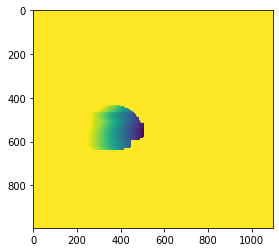

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(thickness)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage as ndi
from skimage.feature import shape_index
from skimage.draw import circle

image = cv2.imread('0511.bmp',0)

ax2 = fig.add_subplot(1, 3, 2, projection='3d')

x, y = np.meshgrid(
    np.arange(0, image.shape[0], 1),
    np.arange(0, image.shape[1], 1)
)

ax2.plot_surface(x, y, image, linewidth=0, alpha=0.5)

fig =plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(np.arange(0,thickness.shape[0],1),np.arange(0,thickness.shape[1],1))

print(X.shape,Y.shape,thickness.shape)
ax.plot_surface(X,Y,thickness)




ImportError: cannot import name 'axes' from 'matplotlib' (C:\Users\Kfor\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py)

In [0]:
#假设得到了二值图，利用二值图做mask到原图上
#原图内只有晶体块的区域内有灰度值
#1.找一个最高的灰度值，该像素点对应这是一个平面，对应灰度值为Imax

# 对应保存的三维数据的表格的文件名，取文件夹中遍历得到的图片的文件名来给表格命名
filename = "filename"+".excel"

#二氧化硅折射率
n = 1.548745

imageTest = cv2.imread("/content/drive/My Drive/sio2_1.png",0)
# 获取图片的长宽
[rows, cols] = np.shape(imageTest)
# 能框住检测到的二氧化硅区域的最小矩形的四个边框的位置信息
leftBorder = 0
rightBorder = cols
upBorder = 0
downBorder = rows




In [0]:
#最小灰度值，代表与CCD(相机)平行,由于边框扣取存在一定误差，可能会将二氧化硅f附近影子也包括进去，对像素点灰度进行排序取存在较大断崖式的地方最为sio2的灰度最低点
imageTestSorted = np.sort(imageTest,axis=None)[:,np.newaxis]
imageTestSorted.astype(np.int)
imageTestSorted = np.delete(imageTestSorted,np.where(imageTestSorted==0))[:,np.newaxis]
imageTestLeft1 = np.concatenate([imageTestSorted[1:],[[np.max(imageTest)]]])
# print(imageTestLeft1.shape)
# imageTestSorted = np.asarray(imageTestSorted)
# print(imageTestSorted[:,np.newaxis].dtype)
# imageTestLeft1 = np.array(imageTestSorted[1:],np.ones((1,1),dtype=np.int)*np.max(imageTest))
# imageTestLeft1 = np.array(imageTestSorted[1:],np.array([np.max(imageTest)]))
# imageTestLeft1 = np.ndarray(imageTestSorted[1:],np.max(imageTest))

In [0]:
# 最小灰度值，代表与CCD(相机)平行,由于边框扣取存在一定误差，可能会将二氧化硅f附近影子也包括进去，对像素点灰度进行排序取存在较大断崖式的地方最为sio2的灰度最低点
imageTestDif = imageTestSorted - imageTestLeft1
if imageTestDif[imageTestDif > 100].any():
    # mingrey_pos = np.index(np.max(imageTestDif))
    mingrey_pos = np.unravel_index(np.argmax(imageTestDif), imageTestDif.shape)
    min_grey = imageTestSorted[mingrey_pos[0], mingrey_pos[1]]
    [mingrey_pos_x, mingrey_pos_y] = np.unravel_index(
        min_grey, imageTest.shape)
elif np.min(imageTest) > 15:
    min_grey = np.min(imageTest)
else:
    min_grey = 15
# min_grey = np.min(imageTest)
# [mingrey_pos_x,mingrey_pos_y] = np.unravel_index(np.argmax(imageTest),imageTest.shape)
# 最大反射光强
max_I = min_grey*math.pow(n+1, 2)/math.pow(n-1, 2)

# 用于存储物体高度的一个矩阵，将最高点定义为0，其余点均为负数
thickness = np.zeros([rows, cols])
thickness[mingrey_pos_x, mingrey_pos_y] = 0

In [0]:
rou = imageTest / max_I

x = sy.symbols('xi_ta')
y = sy.symbols('rou')
# expr = -1.061*x**5-3.3437*x**4+4.1582*x**3-2.38295*x**2+0.57975*x+0.0083-y

# 对最小灰度值的点（即高度最高的点）左上部分根据灰度值求得高度变化的斜率从而计算坐上部分的高度
for i in np.arange(upBorder+1, mingrey_pos_y)[::-1]:
    for j in np.arange(leftBorder+1, mingrey_pos_x)[::-1]:
        if(imageTest[i, j] != 0):
            expr = "0.03175*x**2-0.01495*x+0.0476-"+str(imageTest[i, j]/max_I)
            expr = sympify(expr)
            dhdx = sy.solve(expr)[1]
            if np.complex(dhdx):
                thickness[i, j] = -255
            else:
                thickness[i, j] = thickness[i, j+1] - dhdx
    if(i > upBorder+1 and imageTest[i-1, mingrey_pos_y] != 0):
        expr = "0.03175*x**2-0.01495*x+0.0476-" + \
            str(imageTest[i-1, mingrey_pos_y])
        expr = sympify(expr)
        dhdx = sy.solve(expr)[1]
        if np.iscomplex(dhdx):
            thickness[i-1, mingrey_pos_y] = -255
        else:
            thickness[i-1, mingrey_pos_y] = thickness[i, mingrey_pos_y] - dhdx
# 对最小灰度值的点（即高度最高的点）右上部分根据灰度值求得高度变化的斜率从而计算坐上部分的高度
for i in np.arange(upBorder+1, mingrey_pos_y)[::-1]:
    for j in np.arange(mingrey_pos_x+1, rightBorder):
        if(imageTest[i, j] != 0):
            expr = "0.03175*x**2-0.01495*x+0.0476-"+str(imageTest[i, j]/max_I)
            expr = sympify(expr)
            dhdx = sy.solve(expr)[1]
            if np.iscomplex(dhdx):
                thickness[i, j] = -255
            else:
                thickness[i, j] = thickness[i, j-1] - dhdx
            print(thickness[i, j])
    if(i > upBorder+1 and imageTest[i-1, mingrey_pos_y] != 0):
        expr = "0.03175*x**2-0.01495*x+0.0476-" + \
            str(imageTest[i-1, mingrey_pos_y])
        expr = sympify(expr)
        dhdx = sy.solve(expr)[1]
        if np.iscomplex(dhdx):
            thickness[i-1, mingrey_pos_y] = -255
        else:
            thickness[i-1, mingrey_pos_y] = thickness[i, mingrey_pos_y] - dhdx
        print(thickness[i-1, mingrey_pos_y])
# 对最小灰度值的点（即高度最高的点）左下部分根据灰度值求得高度变化的斜率从而计算坐上部分的高度
for i in np.arange(mingrey_pos_y+1, downBorder):
    for j in np.arange(leftBorder+1, mingrey_pos_x)[::-1]:
        if(imageTest[i, j] != 0):
            expr = "0.03175*x**2-0.01495*x+0.0476-"+str(imageTest[i, j]/max_I)
            expr = sympify(expr)
            dhdx = sy.solve(expr)[1]
            if np.iscomplex(dhdx):
                thickness[i, j] = -255
            else:
                thickness[i, j] = thickness[i, j+1] - dhdx
            print(thickness[i, j])
    if(i > downBorder-1 and imageTest[i+1, mingrey_pos_y] != 0):
        expr = "0.03175*x**2-0.01495*x+0.0476-" + \
            str(imageTest[i-1, mingrey_pos_y]/max_I)
        expr = sympify(expr)
        dhdx = sy.solve(expr)[1]
        if np.iscomplex(dhdx):
            thickness[i+1, mingrey_pos_y] = -255
        else:
            thickness[i+1, mingrey_pos_y] = thickness[i, mingrey_pos_y] - dhdx
        print(thickness[i-1, mingrey_pos_y])
# 对最小灰度值的点（即高度最高的点）右下部分根据灰度值求得高度变化的斜率从而计算坐上部分的高度
for i in np.arange(mingrey_pos_y+1, downBorder):
    for j in np.arange(mingrey_pos_x+1, rightBorder):
        if(imageTest[i, j] != 0):
            expr = "0.03175*x**2-0.01495*x+0.0476-"+str(imageTest[i, j]/max_I)
            expr = sympify(expr)
            dhdx = sy.solve(expr)[1]
            if np.iscomplex(dhdx):
                thickness[i, j] = -255
            else:
                thickness[i, j] = thickness[i, j-1] - dhdx
            print(thickness[i, j])
    if(i > downBorder-1 and imageTest[i+1, mingrey_pos_y] != 0):
        expr = "0.03175*x**2-0.01495*x+0.0476-" + \
            str(imageTest[i-1, mingrey_pos_y]/max_I)
        expr = sympify(expr)
        dhdx = sy.solve(expr)[1]
        if np.iscomplex(dhdx):
            thickness[i+1, mingrey_pos_y] = -255
        else:
            thickness[i+1, mingrey_pos_y] = thickness[i, mingrey_pos_y] - dhdx
        print(thickness[i-1, mingrey_pos_y])
thickness_mat = pd.DataFrame(thickness)
thickness_mat.to_excel("./3dModel/"+filename, index=False)
# print(thickness)

# expr.sub(y,1)

# res = sy.solve([expr],[x])
# print(sy.solve(expr))

-0.3626672770488018
-6.877864964090532
-10.312672257950538
-0.3626672770488018
-0.3626672770488018
-1.4504067142072632
-3.3993547003292557
-5.731477012736674
-8.386843592273166
-10.718965904680584
-12.667913890802577
-14.61686187692457
-16.565809863046564
-16.928477140095367
-17.29114441714417
-17.653811694192974
-18.016478971241778
-18.37914624829058
-18.741813525339385
-20.19222023954665
-20.554887516595453
-20.917554793644257
-21.28022207069306
-21.642889347741864
-22.005556624790668
-22.36822390183947
-22.730891178888275
-23.093558455937078
-23.45622573298588
-23.818893010034685
-24.18156028708349
-24.544227564132292
-24.906894841181096
-25.2695621182299
-25.632229395278703
-25.994896672327506
-26.35756394937631
-26.720231226425113
-27.082898503473917
-27.44556578052272
-27.808233057571524
-28.170900334620327
-28.53356761166913
-28.896234888717935
-29.258902165766738
-29.62156944281554
-29.984236719864345
-30.34690399691315
-30.709571273961952
-31.072238551010756
-31.43490582805956

In [0]:
# expr = 0.03175*x**2-0.01495*x+0.0476-178/5/2.548745**2*0.548745**2
# print(sy.solve(expr)[1])